In [1]:
# Imports
import json
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

from sklearn import decomposition, manifold
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

from PIL import Image, ImageDraw

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchvision.datasets.folder import is_image_file

from vit_pytorch import ViT

import mlflow
import mlflow.pytorch

from AACN_Model import attention_augmented_resnet18, attention_augmented_inceptionv3, attention_augmented_vgg19

In [2]:
# Setup device
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Data Preprocessing
date_list = [
    '04_11_21',
    '14_09_21',
    '14_09_22',
    '15_07_22',
    '25_05_22',
    '27_07_21'
]

In [4]:
# Set the base directory
base_dir = "/Users/izzymohamed/Desktop/Vision For Social Good/Project/Vision-For-Social-Good/DATA/Peach"

In [5]:
# Define main directories
base_dir = '/Users/izzymohamed/Desktop/Vision For Social Good/Project/Vision-For-Social-Good/DATA/Peach/'
date = date_list[0]
date_dir = os.path.join(base_dir, date)

In [6]:
# Load CSV data
multimodal_data_path = os.path.join(base_dir, "combined_multimodal_data.csv")
multimodal_df = pd.read_csv(multimodal_data_path)

In [7]:
multimodal_df.columns

Index(['Date', 'Tree_ID', 'Orchard_Mapping_Image', 'Aerial_UAV_Image',
       'Ground_RGB_Image', 'Ground_RGB_Image_with_Bounding_Boxes',
       'Ground_RGB_Image_Annotations', 'Multispectral_RGB_Image',
       'Multispectral_REG_Image', 'Multispectral_RED_Image',
       'Multispectral_NIR_Image', 'Multispectral_GRE_Image',
       'Multispectral_RGB_Bounding_Box_Image',
       'Multispectral_RGB_Bounding_Box_Annotation', 'Label', 'UAV_NDVI',
       'UAV_EVI', 'UAV_NDRE', 'UAV_SAVI', 'UAV_GNDVI', 'UAV_RVI', 'UAV_TVI',
       'x1', 'x2', 'y1', 'y2', 'Multispectral_NDVI', 'Multispectral_EVI',
       'Multispectral_NDRE', 'Multispectral_SAVI', 'Multispectral_GNDVI',
       'Multispectral_RVI', 'Multispectral_TVI', 'Multispectral_NDVI_Image',
       'Multispectral_GNDVI_Image', 'Multispectral_NDRE_Image',
       'Multispectral_SAVI_Image', 'date'],
      dtype='object')

In [8]:
# Image columns
image_columns = ['Multispectral_RGB_Bounding_Box_Image', 'Multispectral_RGB_Bounding_Box_Annotation']

In [9]:
# Class mapping
classes = ['Healthy', 'Grapholita molesta', 'Anarsia lineatella', 'Dead Tree']
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

In [10]:
# Remove rows with label = 0
# multimodal_df = multimodal_df[multimodal_df['Label'] != 0]

# Drop rows with missing values for Ground_RGB_Image_Annotations
multimodal_df = multimodal_df.dropna(subset=['Multispectral_RGB_Bounding_Box_Image'])
multimodal_df = multimodal_df.dropna(subset=['Multispectral_RGB_Bounding_Box_Annotation'])

In [11]:
# Function to check if all image columns contain valid strings
def valid_image_paths(row):
    return all(isinstance(row[col], str) for col in image_columns)

In [12]:
# Apply the filter
valid_rows = multimodal_df.apply(valid_image_paths, axis=1)
multimodal_df = multimodal_df[valid_rows]
multimodal_df.reset_index(drop=True, inplace=True)

In [13]:
# Define the models
num_classes_inception = 4  # Adjust this number based on your dataset
num_classes_others = 4  # Adjust this number based on your dataset


In [14]:
# Define the standard image sizes
inception_size = 299
other_size = 224

In [15]:
# Update the data transformations
data_transforms = {
    'InceptionV3': {
        'train': transforms.Compose([
            transforms.Resize((inception_size, inception_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((inception_size, inception_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize((inception_size, inception_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    },
    'Others': {
        'train': transforms.Compose([
            transforms.Resize((other_size, other_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((other_size, other_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize((other_size, other_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
}

In [16]:
# Dataset class for images with annotations
class CustomImageDataset(Dataset):
    def __init__(self, df, image_columns, class_to_idx, transform=None):
        self.df = df
        self.image_columns = image_columns
        self.class_to_idx = class_to_idx
        self.transform = transform

        # Define the mapping from integers to class names
        self.label_to_class_name = {
            0: 'Healthy',
            1: 'Grapholita molesta',
            2: 'Anarsia lineatella',
            3: 'Dead Tree'
        }

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Extract the image path and the corresponding annotation path
        img_path = row['Multispectral_RGB_Bounding_Box_Image']
        annotation_path = row['Multispectral_RGB_Bounding_Box_Annotation']

        images = []

        if isinstance(img_path, str) and img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
            try:
                image = Image.open(img_path).convert('RGB')

                # Handle bounding boxes for the image
                if annotation_path and os.path.exists(annotation_path):
                    with open(annotation_path, 'r') as f:
                        bbox_data = json.load(f)

                    # Apply each bounding box found in the annotation
                    for region in bbox_data.get('regions', []):
                        x1, y1 = min(region['points']['x']), min(region['points']['y'])
                        x2, y2 = max(region['points']['x']), max(region['points']['y'])
                        cropped_image = image.crop((x1, y1, x2, y2))

                        if self.transform:
                            cropped_image = self.transform(cropped_image)
                        images.append(cropped_image)
                else:
                    # If no annotation, just transform the full image
                    if self.transform:
                        image = self.transform(image)
                    images.append(image)

            except Exception as e:
                raise ValueError(f"Could not open image at path {img_path} at index {idx}: {e}")
        else:
            raise ValueError(f"Invalid image path at index {idx}")

        if not images:
            raise ValueError(f"No valid images found for index {idx}")

        # If multiple images are provided, average them; otherwise, take the single image
        images = torch.stack(images).mean(dim=0) if len(images) > 1 else images[0]

        # Get the label for the current row
        label_int = row['Label']
        label_name = self.label_to_class_name.get(label_int, None)
        if label_name is None or label_name not in self.class_to_idx:
            raise KeyError(f"Label '{label_int}' not found in label_to_class_name mapping or class_to_idx dictionary.")
        label = self.class_to_idx[label_name]

        return images, label

In [17]:
# Split data into train, validation, and test sets directly from the CSV
train_df, test_df = train_test_split(multimodal_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

In [18]:
# Initialize the datasets for InceptionV3
train_dataset_inception = CustomImageDataset(train_df, image_columns, class_to_idx, transform=data_transforms['InceptionV3']['train'])
val_dataset_inception = CustomImageDataset(val_df, image_columns, class_to_idx, transform=data_transforms['InceptionV3']['val'])
test_dataset_inception = CustomImageDataset(test_df, image_columns, class_to_idx, transform=data_transforms['InceptionV3']['test'])

# Create DataLoader instances for InceptionV3
train_loader_inception = DataLoader(train_dataset_inception, batch_size=32, shuffle=True)
val_loader_inception = DataLoader(val_dataset_inception, batch_size=32, shuffle=True)
test_loader_inception = DataLoader(test_dataset_inception, batch_size=32, shuffle=False)

In [19]:
# Initialize the datasets for other models (ResNet, VGG, etc.)
train_dataset_others = CustomImageDataset(train_df, image_columns, class_to_idx, transform=data_transforms['Others']['train'])
val_dataset_others = CustomImageDataset(val_df, image_columns, class_to_idx, transform=data_transforms['Others']['val'])
test_dataset_others = CustomImageDataset(test_df, image_columns, class_to_idx, transform=data_transforms['Others']['test'])

# Create DataLoader instances for other models
train_loader_others = DataLoader(train_dataset_others, batch_size=32, shuffle=True)
val_loader_others = DataLoader(val_dataset_others, batch_size=32, shuffle=True)
test_loader_others = DataLoader(test_dataset_others, batch_size=32, shuffle=False)

In [20]:
# Model definition
class ImageModel(nn.Module):
    def __init__(self, model_name, image_feature_extractor, num_classes):
        super(ImageModel, self).__init__()
        self.model_name = model_name
        self.image_feature_extractor, self.feature_size = self.initialize_image_feature_extractor(model_name, image_feature_extractor)
        self.classifier = nn.Linear(self.feature_size, num_classes)

    def initialize_image_feature_extractor(self, model_name, image_feature_extractor):
        if model_name == 'InceptionV3':
            feature_size = image_feature_extractor.fc.in_features
            image_feature_extractor.aux_logits = False
            image_feature_extractor.AuxLogits = None
            image_feature_extractor.fc = nn.Identity()
        elif model_name in ['ResNet152', 'AttentionAugmentedResNet18']:
            feature_size = image_feature_extractor.fc.in_features
            image_feature_extractor.fc = nn.Identity()
        elif model_name in ['VGG19', 'AttentionAugmentedVGG19']:
            feature_size = image_feature_extractor.classifier[6].in_features
            image_feature_extractor.classifier[6] = nn.Identity()
        elif model_name == 'ViT':
            if hasattr(image_feature_extractor, 'heads'):
                feature_size = image_feature_extractor.heads.head.in_features
                image_feature_extractor.heads.head = nn.Identity()
            elif hasattr(image_feature_extractor, 'classifier'):
                feature_size = image_feature_extractor.classifier.in_features
                image_feature_extractor.classifier = nn.Identity()
            else:
                for attr_name in dir(image_feature_extractor):
                    attr = getattr(image_feature_extractor, attr_name)
                    if isinstance(attr, nn.Linear):
                        feature_size = attr.in_features
                        setattr(image_feature_extractor, attr_name, nn.Identity())
                        break
                else:
                    raise ValueError(f"Unsupported ViT model structure for model: {model_name}")
        else:
            raise ValueError(f"Unsupported model type: {model_name}")

        return image_feature_extractor, feature_size

    def forward(self, img):
        img_features = self.image_feature_extractor(img)
        if isinstance(img_features, tuple):
            img_features = img_features[0]
        output = self.classifier(img_features)
        return output


In [21]:
# Function to evaluate the model with confidence level
def evaluate_model(model, test_loader, criterion, device, num_classes):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    all_confidences = [[] for _ in range(num_classes)]
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs_img, labels in test_loader:
            inputs_img, labels = inputs_img.to(device), labels.to(device)
            outputs = model(inputs_img)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            softmax_outputs = F.softmax(outputs, dim=1)
            confidence, predicted = torch.max(softmax_outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for i in range(len(labels)):
                class_label = labels[i].item()
                all_confidences[class_label].append(softmax_outputs[i, class_label].item())

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total

    avg_confidences_per_class = [np.mean(confidences) if confidences else 0 for confidences in all_confidences]

    return test_loss, test_accuracy, avg_confidences_per_class, all_predictions, all_labels

In [22]:
# Function to train the model
def train_model(model_name, model, criterion, optimizer, train_loader, val_loader, device, num_epochs=40, initial_lr=0.001, save_path=''):
    early_stopping_patience = 5
    best_val_loss = float("inf")
    patience_counter = 0

    model.to(device)

    with mlflow.start_run(run_name=f"{model_name}"):
        mlflow.log_param("model_name", model_name)
        mlflow.log_param("num_epochs", num_epochs)
        mlflow.log_param("learning_rate", initial_lr)

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            for inputs_img, labels in train_loader:
                inputs_img, labels = inputs_img.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs_img)
                
                if isinstance(outputs, tuple):  # For InceptionV3, get the primary output
                    outputs = outputs[0]
                
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_loss = running_loss / len(train_loader)
            train_accuracy = 100 * correct / total

            # Validation
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs_img, labels in val_loader:
                    inputs_img, labels = inputs_img.to(device), labels.to(device)
                    outputs = model(inputs_img)
                    
                    if isinstance(outputs, tuple):  # For InceptionV3, get the primary output
                        outputs = outputs[0]
                    
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            val_loss /= len(val_loader)
            val_accuracy = 100 * correct / total

            mlflow.log_metric("train_loss", train_loss, step=epoch)
            mlflow.log_metric("train_accuracy", train_accuracy, step=epoch)
            mlflow.log_metric("val_loss", val_loss, step=epoch)
            mlflow.log_metric("val_accuracy", val_accuracy, step=epoch)

            print(f'Epoch {epoch + 1}/{num_epochs}, '
                f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
                f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                checkpoint = {
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_val_loss': best_val_loss,
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                    'train_accuracy': train_accuracy,
                    'val_accuracy': val_accuracy
                }
                torch.save(checkpoint, os.path.join(save_path, f'{model_name}_model_checkpoint.pth'))
                print(f"Checkpoint saved to {model_name}_model_checkpoint.pth")
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print("Early stopping due to no improvement in validation loss.")
                    break

        mlflow.pytorch.log_model(model, f"{model_name}_model")

    return model

In [23]:
# Function to create and train the model
def create_and_train_fusion_model(model, train_loader, val_loader, device, num_epochs=40, initial_lr=0.001):
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
    return train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=num_epochs, initial_lr=initial_lr)

In [24]:
# Clear cache function
def clear_cache():
    if torch.backends.mps.is_available():
        torch.mps.empty_cache()
    elif torch.cuda.is_available():
        torch.cuda.empty_cache()
    else:
        torch.cache.empty_cache()

In [25]:
class Tee(object):
    def __init__(self, *files):
        self.files = files

    def write(self, obj):
        for f in self.files:
            f.write(obj)
            f.flush()  # Make sure the output is written immediately

    def flush(self):
        for f in self.files:
            f.flush()

In [26]:
# Create a results folder
results_base_dir = "/Users/izzymohamed/Desktop/Vision For Social Good/Project/Vision-For-Social-Good/RESULTS/Single"
results_folder = os.path.join(results_base_dir,'Peach', 'Multispectral', 'T4')
os.makedirs(results_folder, exist_ok=True)

In [27]:
# Define the results dictionary to store model performance
crop_results = {}

# Open the file to save the train, validation, and test results
with open(os.path.join(results_folder, 'train_val_test_resuls3.txt'), 'w') as f:

    # Define the models to be trained
    cnn_feature_extractors = {
        'InceptionV3': models.inception_v3(pretrained=True).to(device),
        'ResNet152': models.resnet152(pretrained=True).to(device),
        'VGG19': models.vgg19(pretrained=True).to(device),
        'ViT': ViT(
            image_size=224,
            patch_size=16,
            num_classes=num_classes_others,
            dim=256,
            depth=6,
            heads=24,
            mlp_dim=2048,
            dropout=0.1,
            emb_dropout=0.1
        ).to(device),
        "AttentionAugmentedInceptionV3": attention_augmented_inceptionv3(attention=True).to(device),
        "AttentionAugmentedResNet18": attention_augmented_resnet18(num_classes=num_classes_others, attention=[False, True, True, True], num_heads=8).to(device),
    }

    # Ensure InceptionV3 does not use aux_logits
    if 'InceptionV3' in cnn_feature_extractors:
        cnn_feature_extractors['InceptionV3'].aux_logits = False

    # Iterate over each model in the dictionary
    for model_name, base_model in cnn_feature_extractors.items():
        if model_name == 'InceptionV3':
            base_model.fc = nn.Linear(base_model.fc.in_features, num_classes_others).to(device)
            train_loader = train_loader_inception
            val_loader = val_loader_inception
        elif model_name == 'ResNet152':
            base_model.fc = nn.Linear(base_model.fc.in_features, num_classes_others).to(device)
            train_loader = train_loader_others
            val_loader = val_loader_others
        elif model_name == 'VGG19':
            base_model.classifier[-1] = nn.Linear(base_model.classifier[-1].in_features, num_classes_others).to(device)
            train_loader = train_loader_others
            val_loader = val_loader_others
        elif model_name == 'ViT':
            if hasattr(base_model, 'heads'):
                base_model.heads.head = nn.Linear(base_model.heads.head.in_features, num_classes_others).to(device)
            elif hasattr(base_model, 'classifier'):
                base_model.classifier = nn.Linear(base_model.classifier.in_features, num_classes_others).to(device)
            else:
                for attr_name in dir(base_model):
                    attr = getattr(base_model, attr_name)
                    if isinstance(attr, nn.Linear):
                        feature_size = attr.in_features
                        setattr(base_model, attr_name, nn.Identity())
                        break
                else:
                    raise ValueError(f"Unsupported ViT model structure for model: {model_name}")
            # base_model.heads.head = nn.Linear(base_model.heads.head.in_features, num_classes_others).to(device)
            train_loader = train_loader_others
            val_loader = val_loader_others
        elif model_name == 'AttentionAugmentedInceptionV3':
            base_model.fc = nn.Linear(base_model.inception.fc.in_features, num_classes_others).to(device)
            train_loader = train_loader_others
            val_loader = val_loader_others
        elif model_name == 'AttentionAugmentedVGG19':
            base_model.classifier[-1] = nn.Linear(base_model.classifier[-1].in_features, num_classes_others).to(device)
            train_loader = train_loader_others
            val_loader = val_loader_others
        elif model_name == 'AttentionAugmentedResNet18':
            base_model.fc = nn.Linear(base_model.fc.in_features, num_classes_others).to(device)
            train_loader = train_loader_others
            val_loader = val_loader_others
        else:
            train_loader = train_loader_others
            val_loader = val_loader_others
        
        print(f'--------------- Training model: {model_name}')
        f.write(f'--------------- Training model: {model_name}\n')

        # Define the loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(base_model.parameters(), lr=1e-4, weight_decay=1e-4)

        # Train the model
        checkpoint_path = os.path.join(results_folder, f'{model_name}_model_checkpoint.pth')
        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path)
            base_model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            best_val_loss = checkpoint['best_val_loss']
            train_loss = checkpoint['train_loss']
            train_accuracy = checkpoint['train_accuracy']
            val_accuracy = checkpoint['val_accuracy']
            val_loss = checkpoint['val_loss']
            print(f"Loaded model checkpoint from {checkpoint_path}")
            print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
                f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
            f.write(f"Loaded model checkpoint from {checkpoint_path}\n")
            trained_model = base_model
        else:
            trained_model = train_model(
                model_name,
                base_model,
                criterion,
                optimizer,
                train_loader,
                val_loader,
                device,
                num_epochs=40,
                initial_lr=0.001,
                save_path=results_folder
            )

        # Evaluate the model on the test set
        test_loss, test_accuracy, _, _, _ = evaluate_model(trained_model, test_loader_others, criterion, device, num_classes_others)

        # Output the results
        output_line = f'{model_name} Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%'
        print(output_line)
        f.write(output_line + '\n')

        # Store the results
        crop_results[model_name] = {
            'model': trained_model,
            'test_loss': test_loss,
            'test_accuracy': test_accuracy
        }

        # Clear GPU memory
        del trained_model
        torch.cuda.empty_cache()
        torch.mps.empty_cache()

        print('\n')
        f.write('\n')

    # Final separator
    final_separator = '----------------------------------------------------------------------------------------------------------------------'
    print(final_separator)
    f.write(final_separator + '\n')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passi

--------------- Training model: InceptionV3
Epoch 1/40, Train Loss: 1.3894, Train Accuracy: 30.97%, Val Loss: 1.2295, Val Accuracy: 47.37%
Checkpoint saved to InceptionV3_model_checkpoint.pth
Epoch 2/40, Train Loss: 0.7787, Train Accuracy: 92.92%, Val Loss: 0.9244, Val Accuracy: 68.42%
Checkpoint saved to InceptionV3_model_checkpoint.pth
Epoch 3/40, Train Loss: 0.4532, Train Accuracy: 98.23%, Val Loss: 0.5844, Val Accuracy: 81.58%
Checkpoint saved to InceptionV3_model_checkpoint.pth
Epoch 4/40, Train Loss: 0.2240, Train Accuracy: 99.12%, Val Loss: 0.3387, Val Accuracy: 89.47%
Checkpoint saved to InceptionV3_model_checkpoint.pth
Epoch 5/40, Train Loss: 0.1111, Train Accuracy: 99.12%, Val Loss: 0.3862, Val Accuracy: 92.11%
Epoch 6/40, Train Loss: 0.0659, Train Accuracy: 100.00%, Val Loss: 0.3009, Val Accuracy: 94.74%
Checkpoint saved to InceptionV3_model_checkpoint.pth
Epoch 7/40, Train Loss: 0.0488, Train Accuracy: 100.00%, Val Loss: 0.1360, Val Accuracy: 94.74%
Checkpoint saved to Ince

2024/08/24 02:24:33 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


InceptionV3 Test Loss: 0.2173, Test Accuracy: 89.47%


--------------- Training model: ResNet152
Epoch 1/40, Train Loss: 0.9000, Train Accuracy: 70.80%, Val Loss: 0.8543, Val Accuracy: 81.58%
Checkpoint saved to ResNet152_model_checkpoint.pth
Epoch 2/40, Train Loss: 0.1794, Train Accuracy: 99.12%, Val Loss: 0.3335, Val Accuracy: 92.11%
Checkpoint saved to ResNet152_model_checkpoint.pth
Epoch 3/40, Train Loss: 0.0572, Train Accuracy: 100.00%, Val Loss: 0.1720, Val Accuracy: 94.74%
Checkpoint saved to ResNet152_model_checkpoint.pth
Epoch 4/40, Train Loss: 0.0148, Train Accuracy: 100.00%, Val Loss: 0.1510, Val Accuracy: 94.74%
Checkpoint saved to ResNet152_model_checkpoint.pth
Epoch 5/40, Train Loss: 0.0145, Train Accuracy: 100.00%, Val Loss: 0.1042, Val Accuracy: 94.74%
Checkpoint saved to ResNet152_model_checkpoint.pth
Epoch 6/40, Train Loss: 0.0229, Train Accuracy: 100.00%, Val Loss: 0.0789, Val Accuracy: 94.74%
Checkpoint saved to ResNet152_model_checkpoint.pth
Epoch 7/40, Train Loss:

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_distutils_hack/__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_distutils_hack/__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/24 02:59:29 WARNING mlflow.models.model: Input example should be provided t

ResNet152 Test Loss: 0.0785, Test Accuracy: 97.37%


--------------- Training model: VGG19
Epoch 1/40, Train Loss: 0.9814, Train Accuracy: 62.83%, Val Loss: 0.8885, Val Accuracy: 78.95%
Checkpoint saved to VGG19_model_checkpoint.pth
Epoch 2/40, Train Loss: 0.4981, Train Accuracy: 87.61%, Val Loss: 0.1951, Val Accuracy: 89.47%
Checkpoint saved to VGG19_model_checkpoint.pth
Epoch 3/40, Train Loss: 0.2150, Train Accuracy: 92.92%, Val Loss: 0.6496, Val Accuracy: 89.47%
Epoch 4/40, Train Loss: 0.2216, Train Accuracy: 91.15%, Val Loss: 0.2757, Val Accuracy: 89.47%
Epoch 5/40, Train Loss: 0.2676, Train Accuracy: 92.04%, Val Loss: 1.8292, Val Accuracy: 89.47%
Epoch 6/40, Train Loss: 0.2704, Train Accuracy: 92.04%, Val Loss: 0.4044, Val Accuracy: 86.84%
Epoch 7/40, Train Loss: 0.2008, Train Accuracy: 94.69%, Val Loss: 0.1817, Val Accuracy: 89.47%
Checkpoint saved to VGG19_model_checkpoint.pth
Epoch 8/40, Train Loss: 0.1530, Train Accuracy: 93.81%, Val Loss: 0.5664, Val Accuracy: 89.47%
Epoch 9/

2024/08/24 03:24:52 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


VGG19 Test Loss: 1.5892, Test Accuracy: 68.42%


--------------- Training model: ViT
Epoch 1/40, Train Loss: 3.6581, Train Accuracy: 26.55%, Val Loss: 1.1112, Val Accuracy: 71.05%
Checkpoint saved to ViT_model_checkpoint.pth
Epoch 2/40, Train Loss: 1.0098, Train Accuracy: 74.34%, Val Loss: 0.7502, Val Accuracy: 76.32%
Checkpoint saved to ViT_model_checkpoint.pth
Epoch 3/40, Train Loss: 0.8248, Train Accuracy: 73.45%, Val Loss: 0.6974, Val Accuracy: 76.32%
Checkpoint saved to ViT_model_checkpoint.pth
Epoch 4/40, Train Loss: 0.7908, Train Accuracy: 70.80%, Val Loss: 0.4796, Val Accuracy: 81.58%
Checkpoint saved to ViT_model_checkpoint.pth
Epoch 5/40, Train Loss: 0.6471, Train Accuracy: 74.34%, Val Loss: 0.4336, Val Accuracy: 81.58%
Checkpoint saved to ViT_model_checkpoint.pth
Epoch 6/40, Train Loss: 0.5990, Train Accuracy: 78.76%, Val Loss: 0.5006, Val Accuracy: 81.58%
Epoch 7/40, Train Loss: 0.5097, Train Accuracy: 80.53%, Val Loss: 0.4779, Val Accuracy: 78.95%
Epoch 8/40, Train Loss: 0

2024/08/24 04:19:16 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


ViT Test Loss: 0.2944, Test Accuracy: 81.58%


--------------- Training model: AttentionAugmentedInceptionV3
Epoch 1/40, Train Loss: 7.4604, Train Accuracy: 0.00%, Val Loss: 7.5850, Val Accuracy: 0.00%
Checkpoint saved to AttentionAugmentedInceptionV3_model_checkpoint.pth
Epoch 2/40, Train Loss: 5.1620, Train Accuracy: 17.70%, Val Loss: 5.2879, Val Accuracy: 7.89%
Checkpoint saved to AttentionAugmentedInceptionV3_model_checkpoint.pth
Epoch 3/40, Train Loss: 3.6046, Train Accuracy: 44.25%, Val Loss: 3.1234, Val Accuracy: 57.89%
Checkpoint saved to AttentionAugmentedInceptionV3_model_checkpoint.pth
Epoch 4/40, Train Loss: 1.7867, Train Accuracy: 78.76%, Val Loss: 1.8716, Val Accuracy: 73.68%
Checkpoint saved to AttentionAugmentedInceptionV3_model_checkpoint.pth
Epoch 5/40, Train Loss: 0.9550, Train Accuracy: 92.92%, Val Loss: 1.2302, Val Accuracy: 86.84%
Checkpoint saved to AttentionAugmentedInceptionV3_model_checkpoint.pth
Epoch 6/40, Train Loss: 0.3293, Train Accuracy: 100.00%, Val Los

2024/08/24 04:46:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


AttentionAugmentedInceptionV3 Test Loss: 0.2907, Test Accuracy: 92.11%


--------------- Training model: AttentionAugmentedResNet18
Epoch 1/40, Train Loss: 1.1650, Train Accuracy: 55.75%, Val Loss: 1.5419, Val Accuracy: 42.11%
Checkpoint saved to AttentionAugmentedResNet18_model_checkpoint.pth
Epoch 2/40, Train Loss: 0.6926, Train Accuracy: 74.34%, Val Loss: 1.2226, Val Accuracy: 57.89%
Checkpoint saved to AttentionAugmentedResNet18_model_checkpoint.pth
Epoch 3/40, Train Loss: 0.5131, Train Accuracy: 76.99%, Val Loss: 1.2724, Val Accuracy: 57.89%
Epoch 4/40, Train Loss: 0.3498, Train Accuracy: 90.27%, Val Loss: 1.0600, Val Accuracy: 57.89%
Checkpoint saved to AttentionAugmentedResNet18_model_checkpoint.pth
Epoch 5/40, Train Loss: 0.3019, Train Accuracy: 94.69%, Val Loss: 0.9711, Val Accuracy: 60.53%
Checkpoint saved to AttentionAugmentedResNet18_model_checkpoint.pth
Epoch 6/40, Train Loss: 0.2543, Train Accuracy: 93.81%, Val Loss: 0.6978, Val Accuracy: 65.79%
Checkpoint saved to Attent

2024/08/24 05:14:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


AttentionAugmentedResNet18 Test Loss: 0.2066, Test Accuracy: 92.11%


----------------------------------------------------------------------------------------------------------------------


# Display Results

In [28]:
# Function to save figures
def save_figure(fig, filename):
    fig.savefig(os.path.join(results_folder, filename))
    plt.close(fig)

In [29]:
# List of classes
classes = ["Anarsia lineatella", "Grapholita molesta", "Dead Trees", "Healthy"]

### Accuracy Comparision

In [30]:
# Plot comparison of accuracy for each model
def plot_accuracy_comparison(results):
    accuracies = [result['test_accuracy'] for result in results.values()]  # Convert accuracy to percentage
    model_names = list(results.keys())

    fig = plt.figure(figsize=(20, 10))
    plt.bar(model_names, accuracies)
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Model')
    plt.show()
    save_figure(fig, 'accuracy_comparison.png')

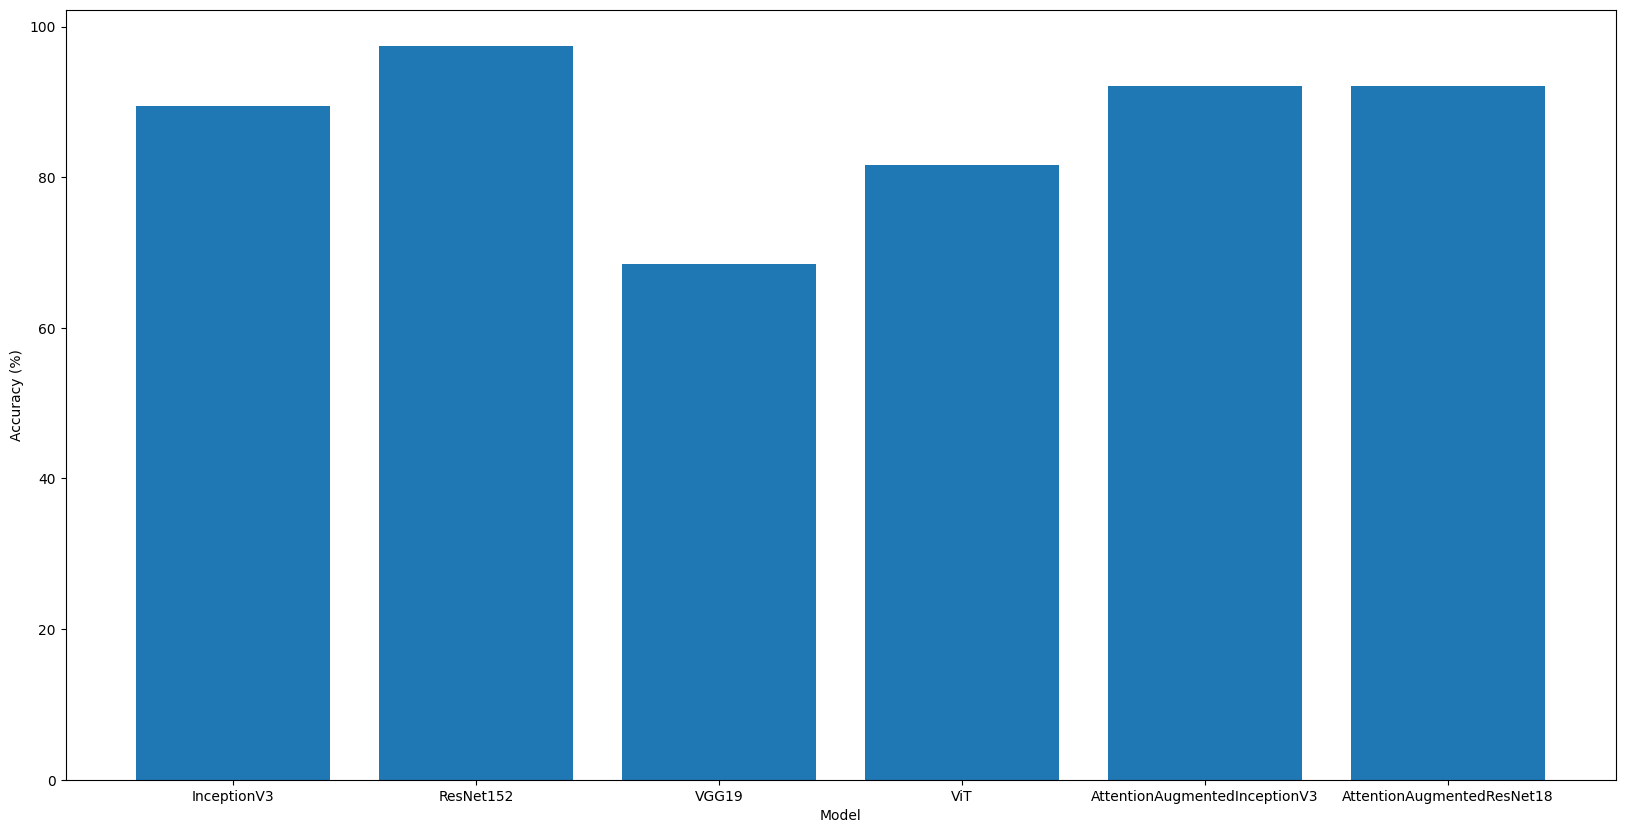

In [31]:
# Plot comparison of accuracy for each model for each crop
plot_accuracy_comparison(crop_results)

### Metrics Table

In [32]:
# Function to display F1, precision, and recall of all models as a table
def display_model_metrics_table(results, test_loader):
    metrics_data = []
    
    for model_name, model_info in crop_results.items():
        model = model_info['model']
        device = next(model.parameters()).device  # Get the device of the model
        model.eval()  # Set the model to evaluation mode

        all_labels = []
        all_predicted = []

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            with torch.no_grad():
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predicted, average='macro')
        
        metrics_data.append({
            'Model': model_name,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1
        })

    metrics_df = pd.DataFrame(metrics_data)
    display(metrics_df)  # Display the DataFrame in Jupyter Notebook
    metrics_df.to_csv(os.path.join(results_folder, 'model_metrics.csv'), index=False)

    # Display result in latex format
    print(metrics_df.to_latex(index=False))

In [33]:
# Display the table of metrics for all models
display_model_metrics_table(crop_results, test_loader_others)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Model  Precision    Recall  F1-score
0                    InceptionV3   0.641009  0.669643  0.654881
1                      ResNet152   0.983333  0.875000  0.908046
2                          VGG19   0.788889  0.698413  0.655520
3                            ViT   0.654386  0.676587  0.659091
4  AttentionAugmentedInceptionV3   0.705592  0.687500  0.690862
5     AttentionAugmentedResNet18   0.666667  0.732143  0.696360

\begin{tabular}{lrrr}
\toprule
Model & Precision & Recall & F1-score \\
\midrule
InceptionV3 & 0.641009 & 0.669643 & 0.654881 \\
ResNet152 & 0.983333 & 0.875000 & 0.908046 \\
VGG19 & 0.788889 & 0.698413 & 0.655520 \\
ViT & 0.654386 & 0.676587 & 0.659091 \\
AttentionAugmentedInceptionV3 & 0.705592 & 0.687500 & 0.690862 \\
AttentionAugmentedResNet18 & 0.666667 & 0.732143 & 0.696360 \\
\bottomrule
\end{tabular}



### Classification Results

In [34]:
# Display some correctly and incorrectly classified images with confidence levels
def display_classification_results(model, test_loader, class_labels, num_images=5):
    model.eval()  # Set the model to evaluation mode
    device = next(model.parameters()).device  # Get the device of the model

    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        confidences, predicted = torch.max(outputs, 1)

    # Debugging: Print the shape of the images tensor
    print(f"Shape of images tensor: {images.shape}")

    if len(images.shape) != 4 or images.shape[1] != 3:
        raise ValueError(f"Expected images of shape (batch_size, 3, H, W), but got {images.shape}")

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        ax = axes[i]
        img = images[i].cpu().numpy()
        
        # Debugging: Print the shape of the individual image tensor
        print(f"Shape of individual image tensor before transpose: {img.shape}")
        
        if img.shape[0] == 3:  # Check if the first dimension is channels
            img = img.transpose((1, 2, 0))  # Move tensor back to CPU for visualization
        else:
            raise ValueError(f"Unexpected image shape: {img.shape}")

        img = np.clip(img, 0, 1)
        ax.imshow(img)

        # Ensure the indices are within the valid range
        if labels[i] < len(class_labels) and predicted[i] < len(class_labels):
            ax.set_title(f'True: {class_labels[labels[i]]}\n'
                         f'Pred: {class_labels[predicted[i].cpu()]}\n'
                         f'Confidence: {confidences[i].item():.2f}')
        else:
            ax.set_title('Invalid label or prediction')

        ax.axis('off')

    plt.show()
    save_figure(fig, f'{model_name}_classification_results.png')

Displaying results for InceptionV3
Shape of images tensor: torch.Size([32, 3, 224, 224])
Shape of individual image tensor before transpose: (3, 224, 224)
Shape of individual image tensor before transpose: (3, 224, 224)
Shape of individual image tensor before transpose: (3, 224, 224)
Shape of individual image tensor before transpose: (3, 224, 224)
Shape of individual image tensor before transpose: (3, 224, 224)


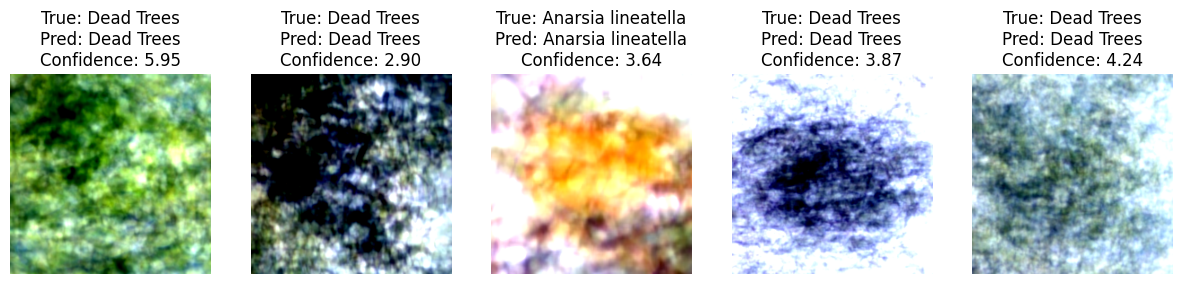

Displaying results for ResNet152
Shape of images tensor: torch.Size([32, 3, 224, 224])
Shape of individual image tensor before transpose: (3, 224, 224)
Shape of individual image tensor before transpose: (3, 224, 224)
Shape of individual image tensor before transpose: (3, 224, 224)
Shape of individual image tensor before transpose: (3, 224, 224)
Shape of individual image tensor before transpose: (3, 224, 224)


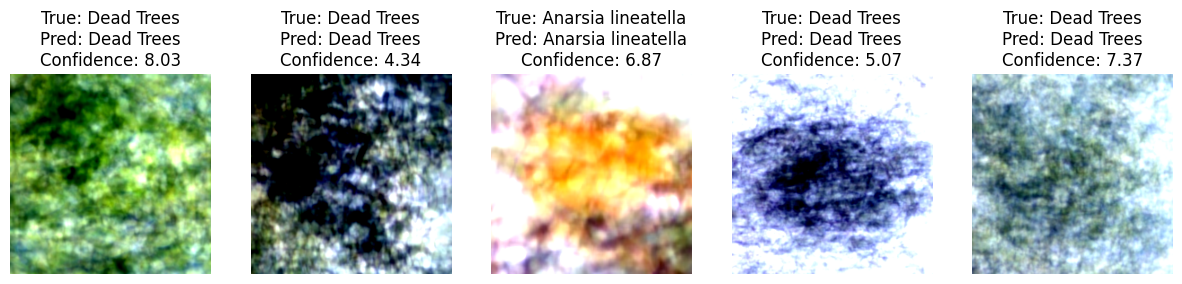

Displaying results for VGG19
Shape of images tensor: torch.Size([32, 3, 224, 224])
Shape of individual image tensor before transpose: (3, 224, 224)
Shape of individual image tensor before transpose: (3, 224, 224)
Shape of individual image tensor before transpose: (3, 224, 224)
Shape of individual image tensor before transpose: (3, 224, 224)
Shape of individual image tensor before transpose: (3, 224, 224)


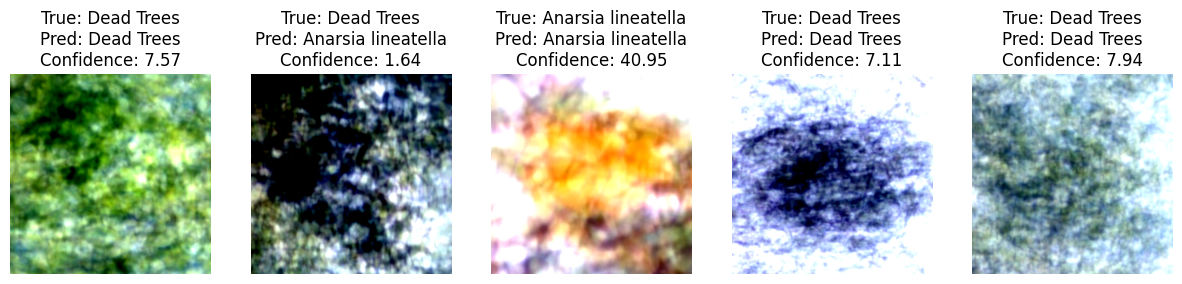

Displaying results for ViT
Shape of images tensor: torch.Size([32, 3, 224, 224])
Shape of individual image tensor before transpose: (3, 224, 224)
Shape of individual image tensor before transpose: (3, 224, 224)
Shape of individual image tensor before transpose: (3, 224, 224)
Shape of individual image tensor before transpose: (3, 224, 224)
Shape of individual image tensor before transpose: (3, 224, 224)


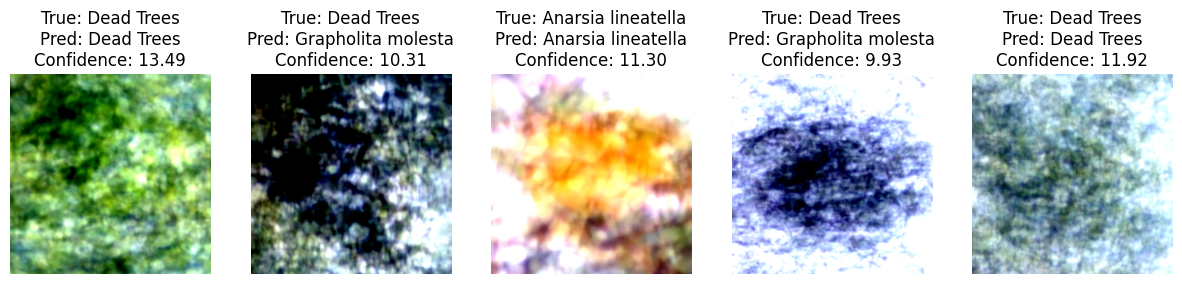

Displaying results for AttentionAugmentedInceptionV3
Shape of images tensor: torch.Size([32, 3, 224, 224])
Shape of individual image tensor before transpose: (3, 224, 224)
Shape of individual image tensor before transpose: (3, 224, 224)
Shape of individual image tensor before transpose: (3, 224, 224)
Shape of individual image tensor before transpose: (3, 224, 224)
Shape of individual image tensor before transpose: (3, 224, 224)


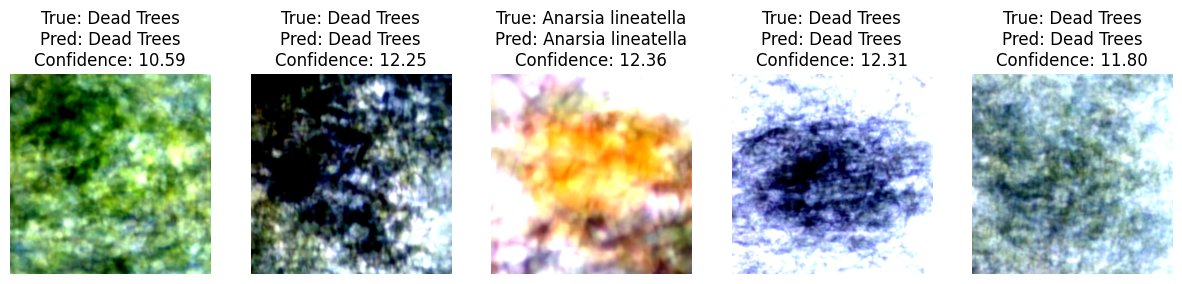

Displaying results for AttentionAugmentedResNet18
Shape of images tensor: torch.Size([32, 3, 224, 224])
Shape of individual image tensor before transpose: (3, 224, 224)
Shape of individual image tensor before transpose: (3, 224, 224)
Shape of individual image tensor before transpose: (3, 224, 224)
Shape of individual image tensor before transpose: (3, 224, 224)
Shape of individual image tensor before transpose: (3, 224, 224)


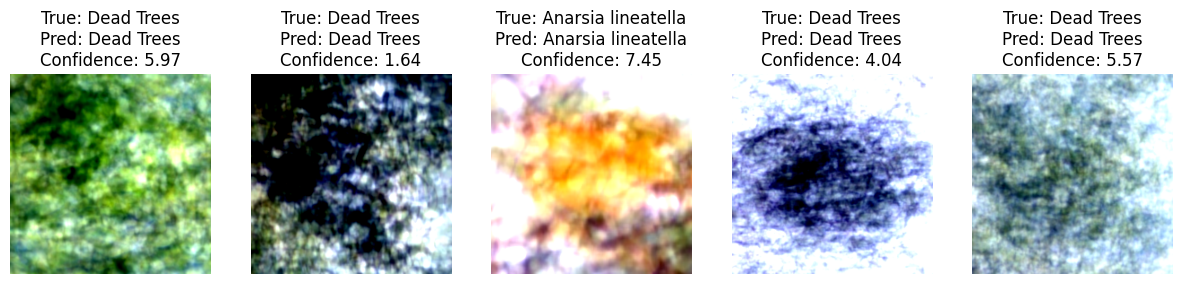

In [35]:
# Display results for each model
for model_name in crop_results.keys():
    print(f'Displaying results for {model_name}')
    display_classification_results(crop_results[model_name]['model'], test_loader_others, classes)

### Classification Report

In [36]:
# Function to display the classification report of a given model
def display_classification_report(model, test_loader, model_name, class_labels):
    model.eval()  # Set the model to evaluation mode
    device = next(model.parameters()).device  # Get the device of the model

    all_labels = []
    all_predicted = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

    # Ensure the labels parameter matches the actual labels in your dataset
    unique_labels = sorted(set(all_labels))
    report = classification_report(all_labels, all_predicted, target_names=class_labels, labels=unique_labels)

    print(report)

    results_folder = 'results'  # Define your results folder
    # Save the report to a file
    with open(f'{results_folder}/{model_name}_classification_report.txt', 'w') as f:
        f.write(report)

In [37]:
# Display results for each crop
for model_name in crop_results.keys():
    print(f'Displaying classification report for {model_name}')
    display_classification_report(crop_results[model_name]['model'], test_loader_others, model_name, classes)

Displaying classification report for InceptionV3


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

                    precision    recall  f1-score   support

Anarsia lineatella       0.75      0.75      0.75         4
Grapholita molesta       0.87      0.93      0.90        14
        Dead Trees       0.95      1.00      0.97        18
           Healthy       0.00      0.00      0.00         2

          accuracy                           0.89        38
         macro avg       0.64      0.67      0.65        38
      weighted avg       0.85      0.89      0.87        38

Displaying classification report for ResNet152
                    precision    recall  f1-score   support

Anarsia lineatella       1.00      1.00      1.00         4
Grapholita molesta       0.93      1.00      0.97        14
        Dead Trees       1.00      1.00      1.00        18
           Healthy       1.00      0.50      0.67         2

          accuracy                           0.97        38
         macro avg       0.98      0.88      0.91        38
      weighted avg       0.98      0.97      0.9

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

                    precision    recall  f1-score   support

Anarsia lineatella       1.00      1.00      1.00         4
Grapholita molesta       0.68      0.93      0.79        14
        Dead Trees       0.93      0.78      0.85        18
           Healthy       0.00      0.00      0.00         2

          accuracy                           0.82        38
         macro avg       0.65      0.68      0.66        38
      weighted avg       0.80      0.82      0.80        38

Displaying classification report for AttentionAugmentedInceptionV3


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

                    precision    recall  f1-score   support

Anarsia lineatella       1.00      0.75      0.86         4
Grapholita molesta       0.88      1.00      0.93        14
        Dead Trees       0.95      1.00      0.97        18
           Healthy       0.00      0.00      0.00         2

          accuracy                           0.92        38
         macro avg       0.71      0.69      0.69        38
      weighted avg       0.88      0.92      0.89        38

Displaying classification report for AttentionAugmentedResNet18
                    precision    recall  f1-score   support

Anarsia lineatella       0.80      1.00      0.89         4
Grapholita molesta       0.87      0.93      0.90        14
        Dead Trees       1.00      1.00      1.00        18
           Healthy       0.00      0.00      0.00         2

          accuracy                           0.92        38
         macro avg       0.67      0.73      0.70        38
      weighted avg       0.88  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

### Incorrect Predictions

In [38]:
# Function to normalize images
def normalize_image(image):
    image = image - image.min()
    image = image / image.max()
    return image

In [39]:
# Function to plot the most incorrect predictions with confidence levels
def plot_most_incorrect(incorrect, classes, n_images, model_name, normalize=True):
    rows = int(np.ceil(np.sqrt(n_images)))
    cols = int(np.ceil(n_images / rows))

    fig = plt.figure(figsize=(25, 20))

    for i in range(rows * cols):
        if i >= len(incorrect):
            break
        ax = fig.add_subplot(rows, cols, i + 1)
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'True: {true_class} ({true_prob:.3f})\n'
                     f'Pred: {incorrect_class} ({incorrect_prob:.3f})\n'
                     f'Confidence: {incorrect_prob.item():.2f}', fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    fig.subplots_adjust(hspace=0.7)
    plt.show()
    save_figure(fig, f'{model_name}_most_incorrect.png')

def get_all_details(model, test_loader):
    all_labels = []
    all_preds = []
    all_probs = []
    all_images = []
    device = next(model.parameters()).device  # Get the device of the model
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            probs = F.softmax(outputs, dim=1)

            all_images.extend(images.cpu())
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu())

    return all_images, all_labels, all_preds, all_probs

# Define the number of images to display
N_IMAGES = 36

# Use this function to get the details
def plot_most_incorrect_predictions(results, test_loader, class_labels, n_images=36):
    for model_name, model_info in results.items():
        model = model_info['model']
        images, labels, pred_labels, probs = get_all_details(model, test_loader)
        corrects = torch.eq(torch.tensor(labels), torch.tensor(pred_labels))
        incorrect_examples = []

        for image, label, prob, correct in zip(images, labels, probs, corrects):
            if not correct:
                incorrect_examples.append((image, label, prob))

    incorrect_examples.sort(key=lambda x: torch.max(x[2], dim=0)[0], reverse=True)
    plot_most_incorrect(incorrect_examples[:n_images], class_labels, n_images, model_name)

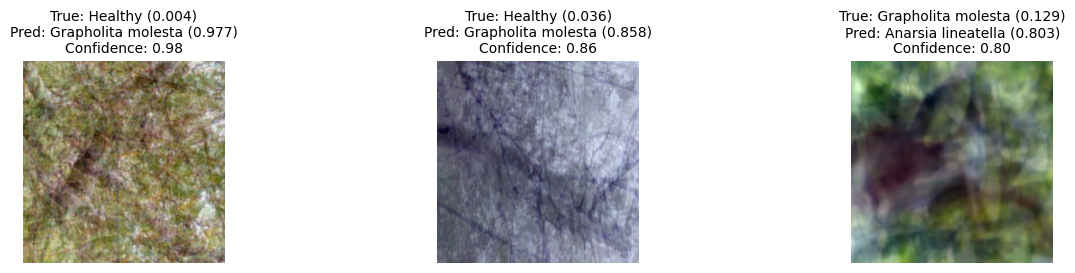

In [40]:
plot_most_incorrect_predictions(crop_results, test_loader_others, classes, N_IMAGES)

### Confusion Matrix

In [41]:
# Function to plot the confusion matrix with confidence levels
def plot_confusion_matrix_with_confidence(model, test_loader, class_labels, model_name):
    model.eval()  # Set the model to evaluation mode
    device = next(model.parameters()).device  # Get the device of the model

    all_labels = []
    all_predicted = []
    all_confidences = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            confidences, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())
            all_confidences.extend(confidences.cpu().numpy())

    # Determine the number of classes
    num_classes = len(class_labels)

    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_predicted, labels=range(num_classes))

    # Initialize the confidence matrix
    confidence_matrix = np.zeros((num_classes, num_classes))

    for true_label in range(num_classes):
        for pred_label in range(num_classes):
            indices = [i for i, (t, p) in enumerate(zip(all_labels, all_predicted)) if t == true_label and p == pred_label]
            if indices:
                avg_confidence = np.mean([all_confidences[i] for i in indices])
                confidence_matrix[true_label, pred_label] = avg_confidence

    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.matshow(confidence_matrix, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    ax.set_xticks(range(num_classes))
    ax.set_yticks(range(num_classes))
    ax.set_xticklabels(class_labels, rotation=45, ha="left")
    ax.set_yticklabels(class_labels)

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix with Confidence for {model_name}')
    plt.show()

    # Save the figure
    save_figure(fig, f'{model_name}_confusion_matrix_with_confidence.png')

Generating confusion matrix with confidence for InceptionV3


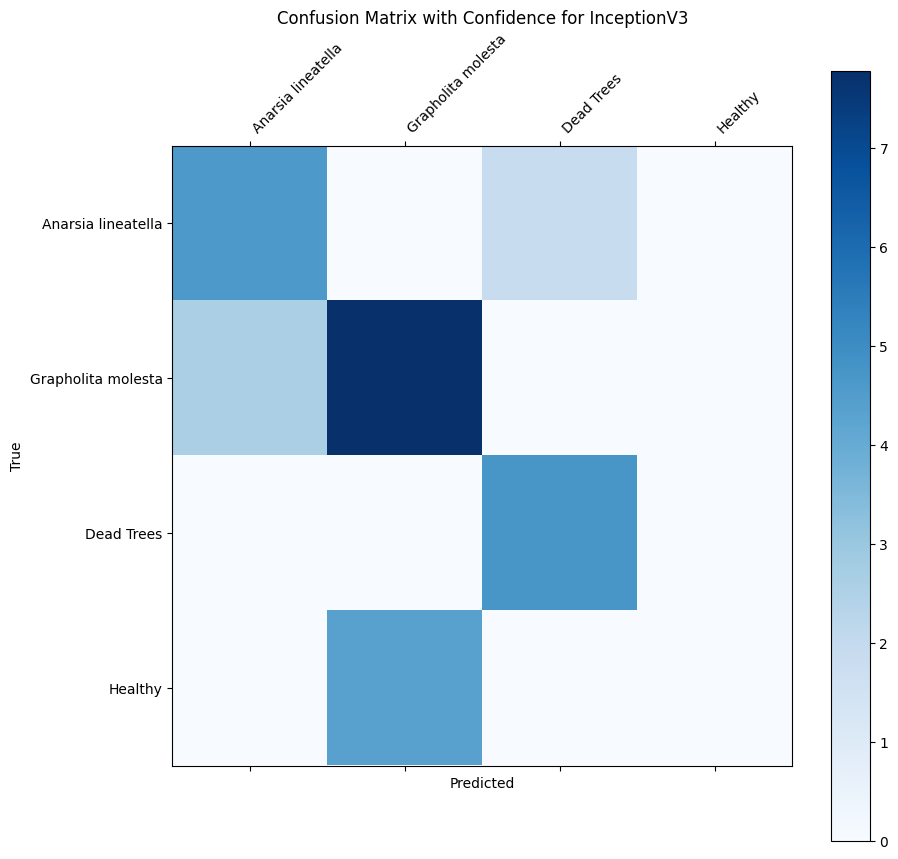

Generating confusion matrix with confidence for ResNet152


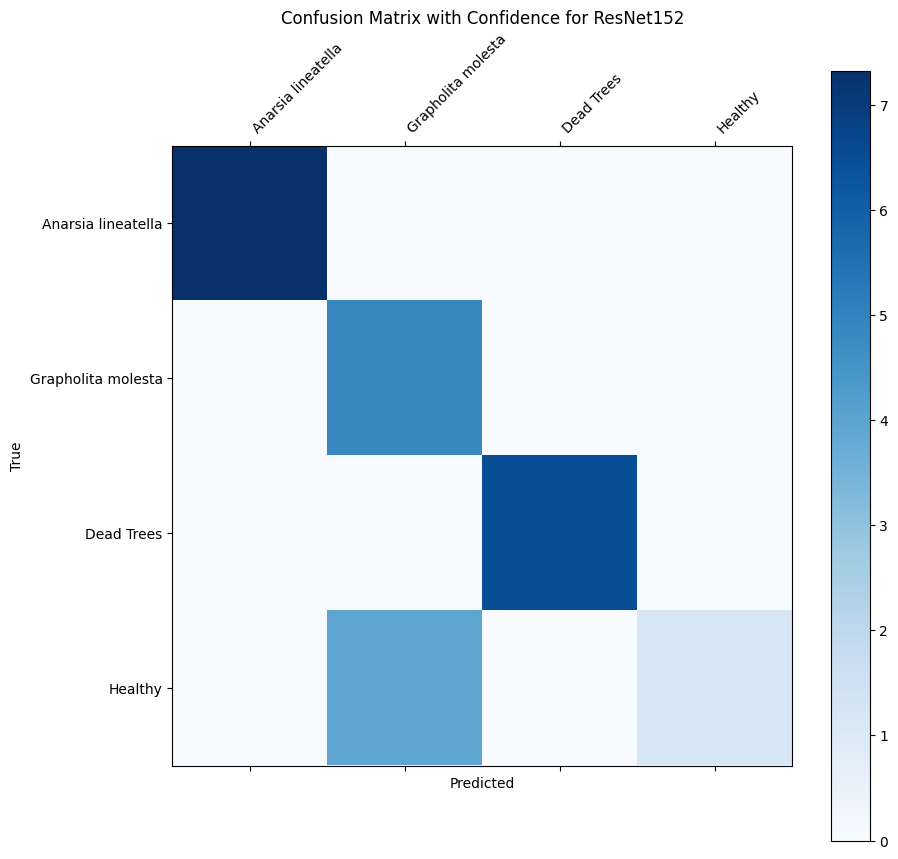

Generating confusion matrix with confidence for VGG19


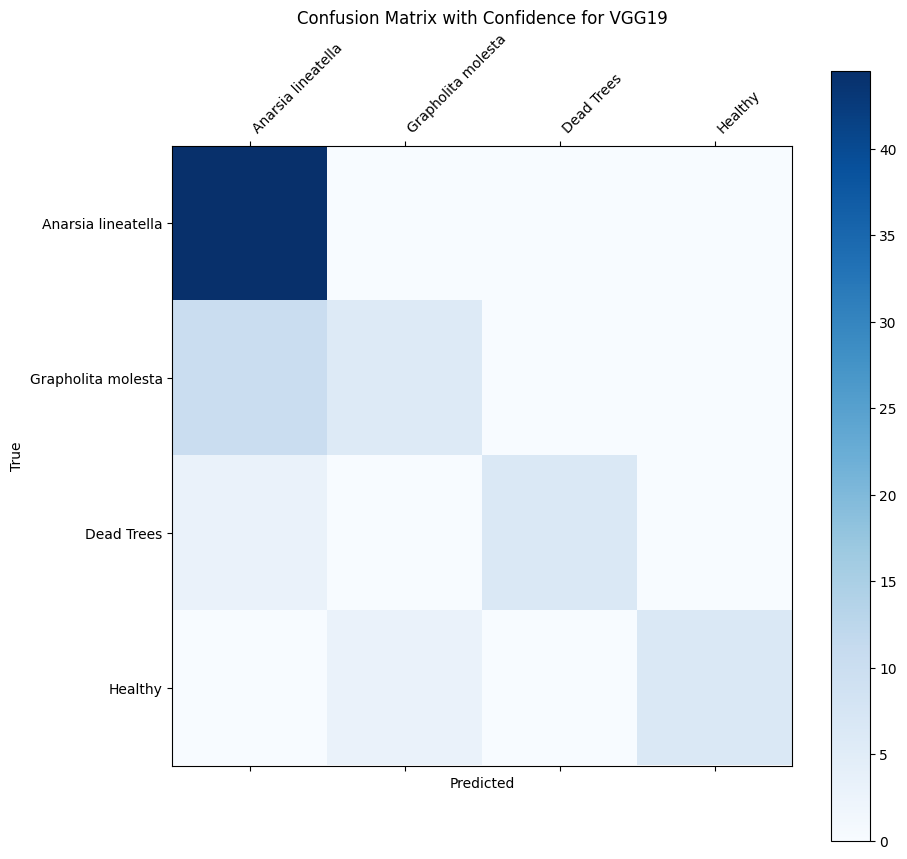

Generating confusion matrix with confidence for ViT


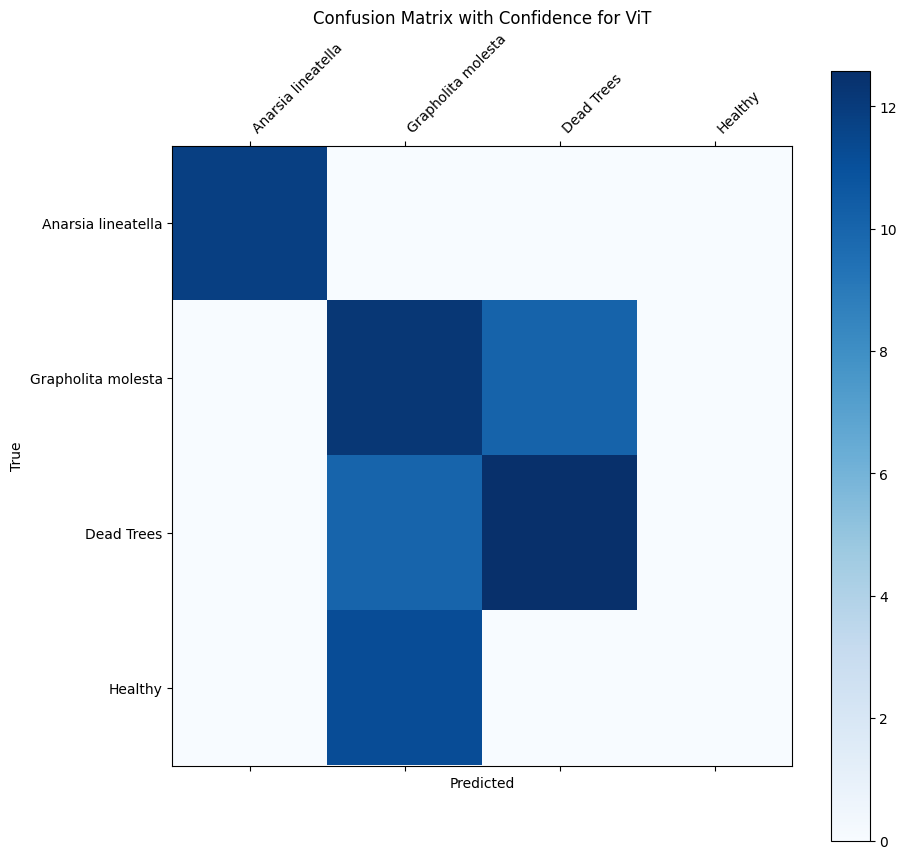

Generating confusion matrix with confidence for AttentionAugmentedInceptionV3


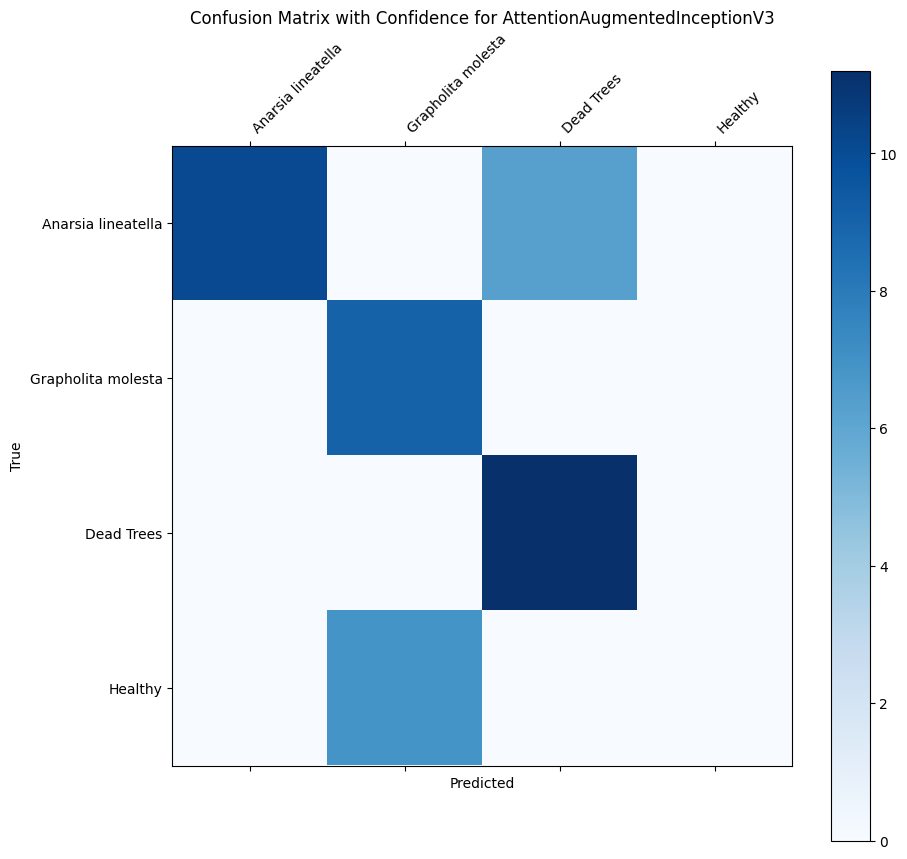

Generating confusion matrix with confidence for AttentionAugmentedResNet18


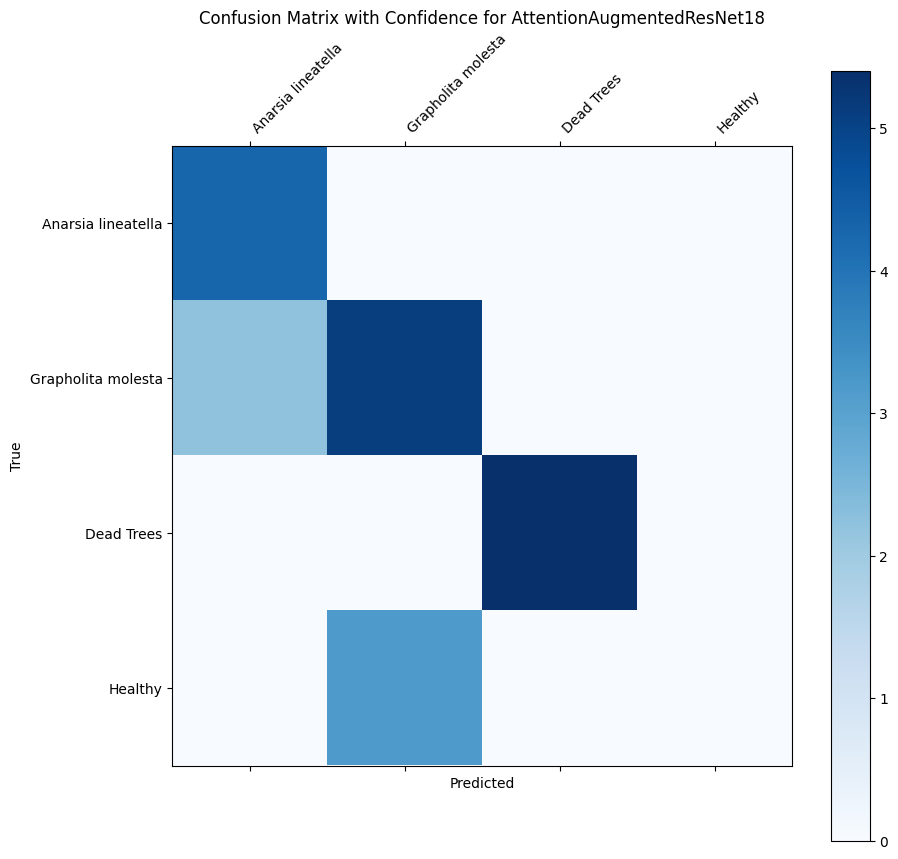

In [42]:
# Example usage for a single model:
for model_name in crop_results.keys():
    print(f'Generating confusion matrix with confidence for {model_name}')
    plot_confusion_matrix_with_confidence(crop_results[model_name]['model'], test_loader_others, classes, model_name)

### Representations and Dimensionality Reduction

In [43]:

def get_representations(model, iterator):
    model.eval()
    outputs = []
    labels = []

    with torch.no_grad():
        for x, y in iterator:
            x = x.to(device)
            y_pred = model(x)
            outputs.append(y_pred.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    labels = torch.cat(labels, dim=0)
    return outputs, labels

In [44]:
def get_pca(data, n_components=2):
    pca = decomposition.PCA(n_components=n_components)
    pca_data = pca.fit_transform(data)
    return pca_data

In [45]:
def plot_representations(data, labels, classes, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]

    fig = plt.figure(figsize=(15, 15))
    # fig.suptitle(f'{model_name} - PCA', fontsize=28, y=0.95)
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='hsv')
    plt.show()
    save_figure(fig, f'{model_name}_pca.png')

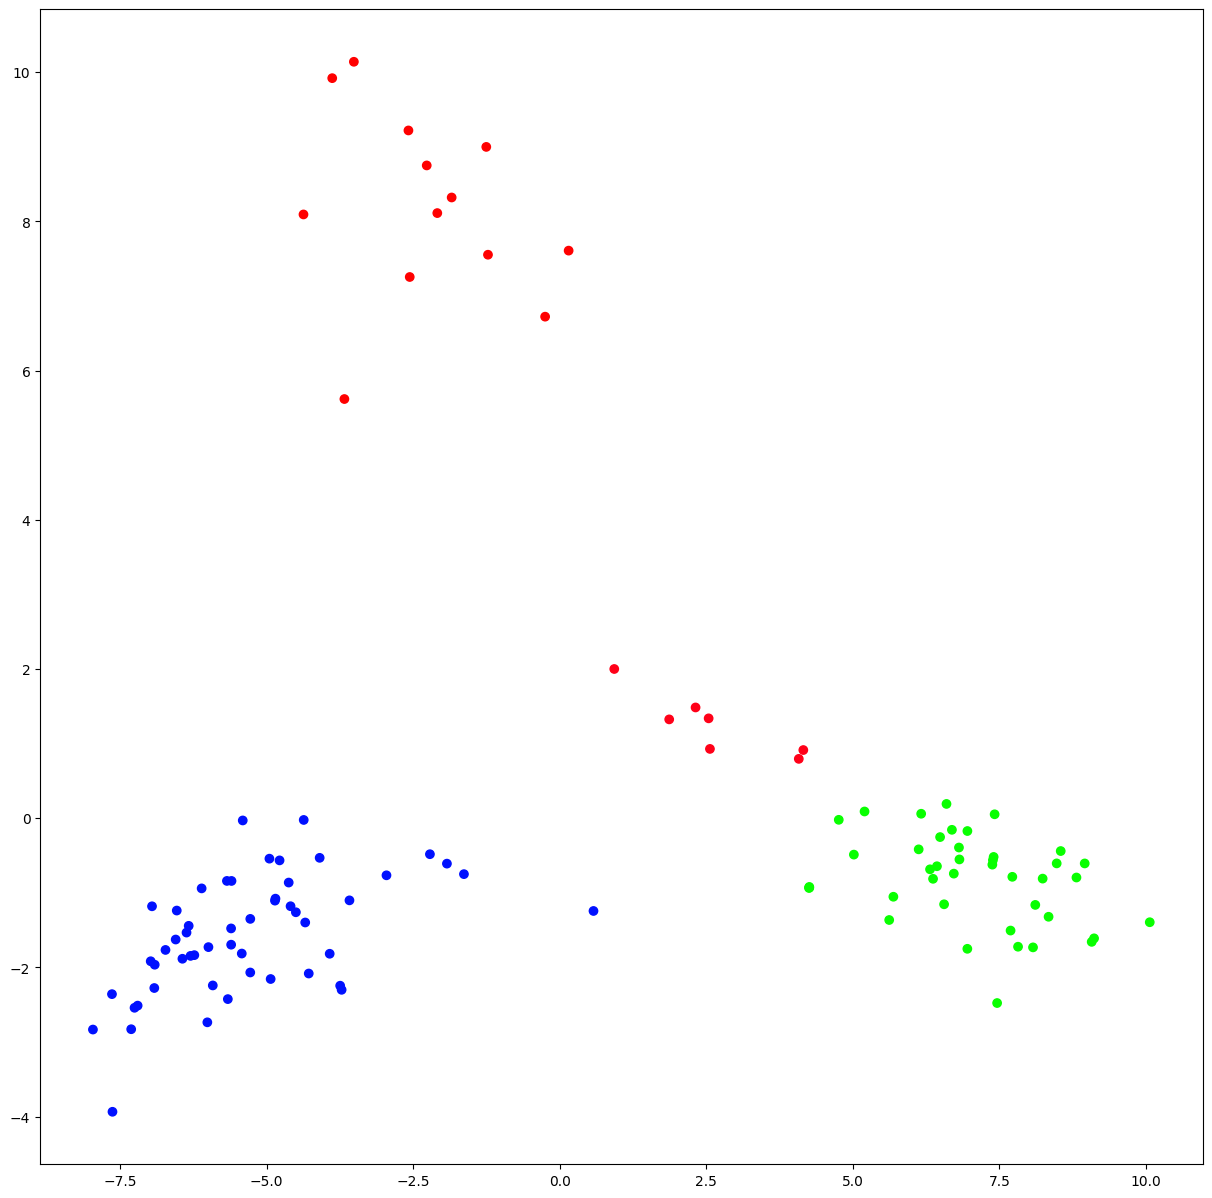

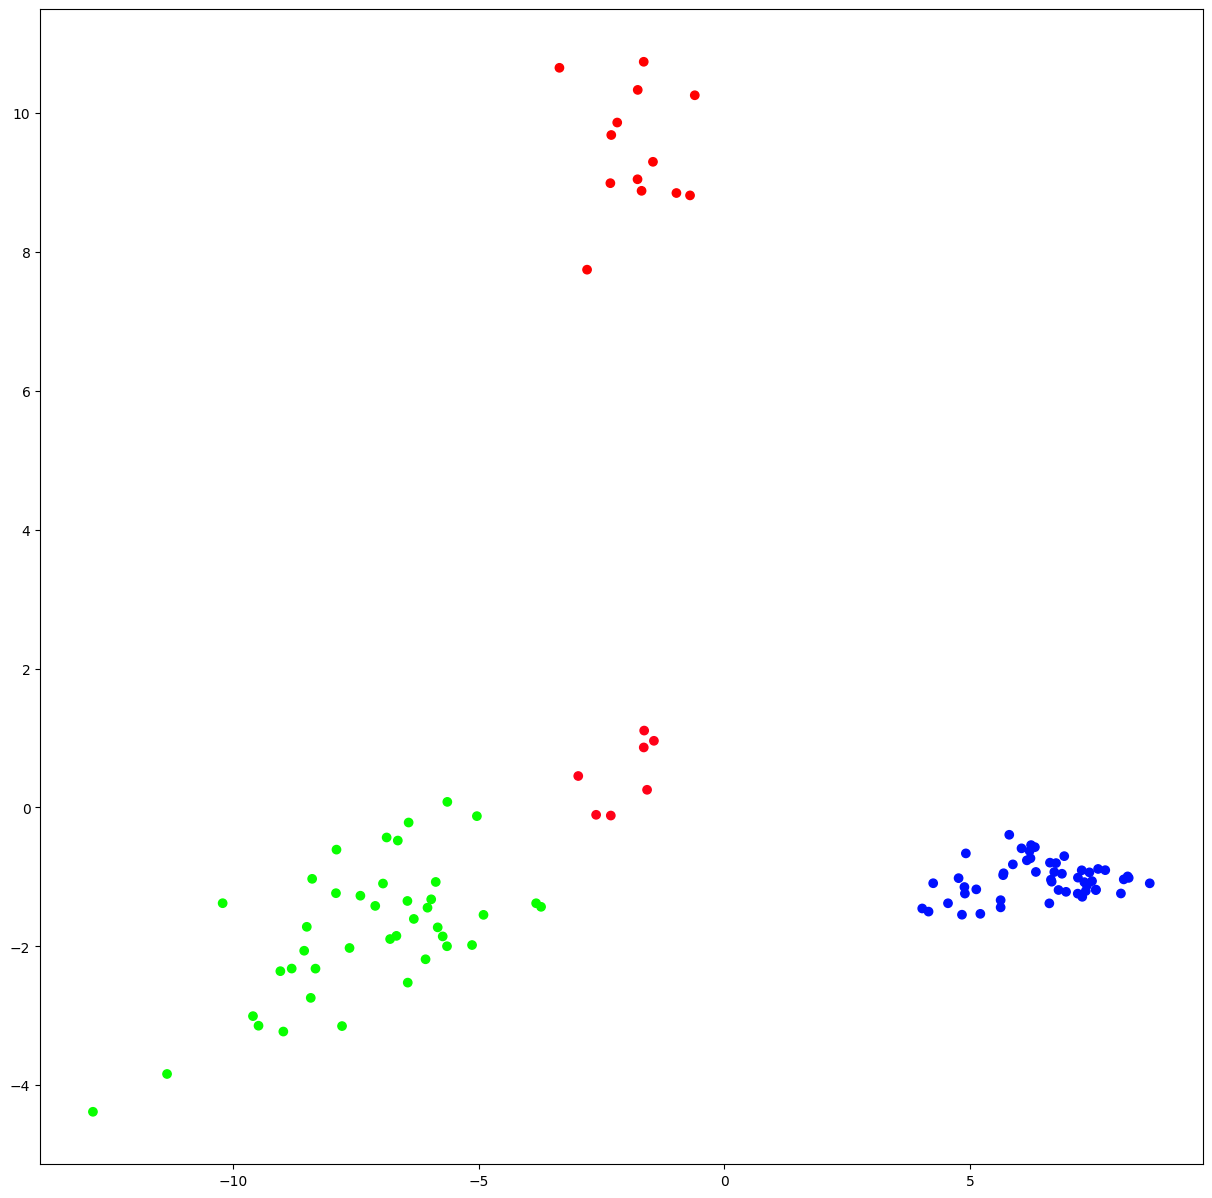

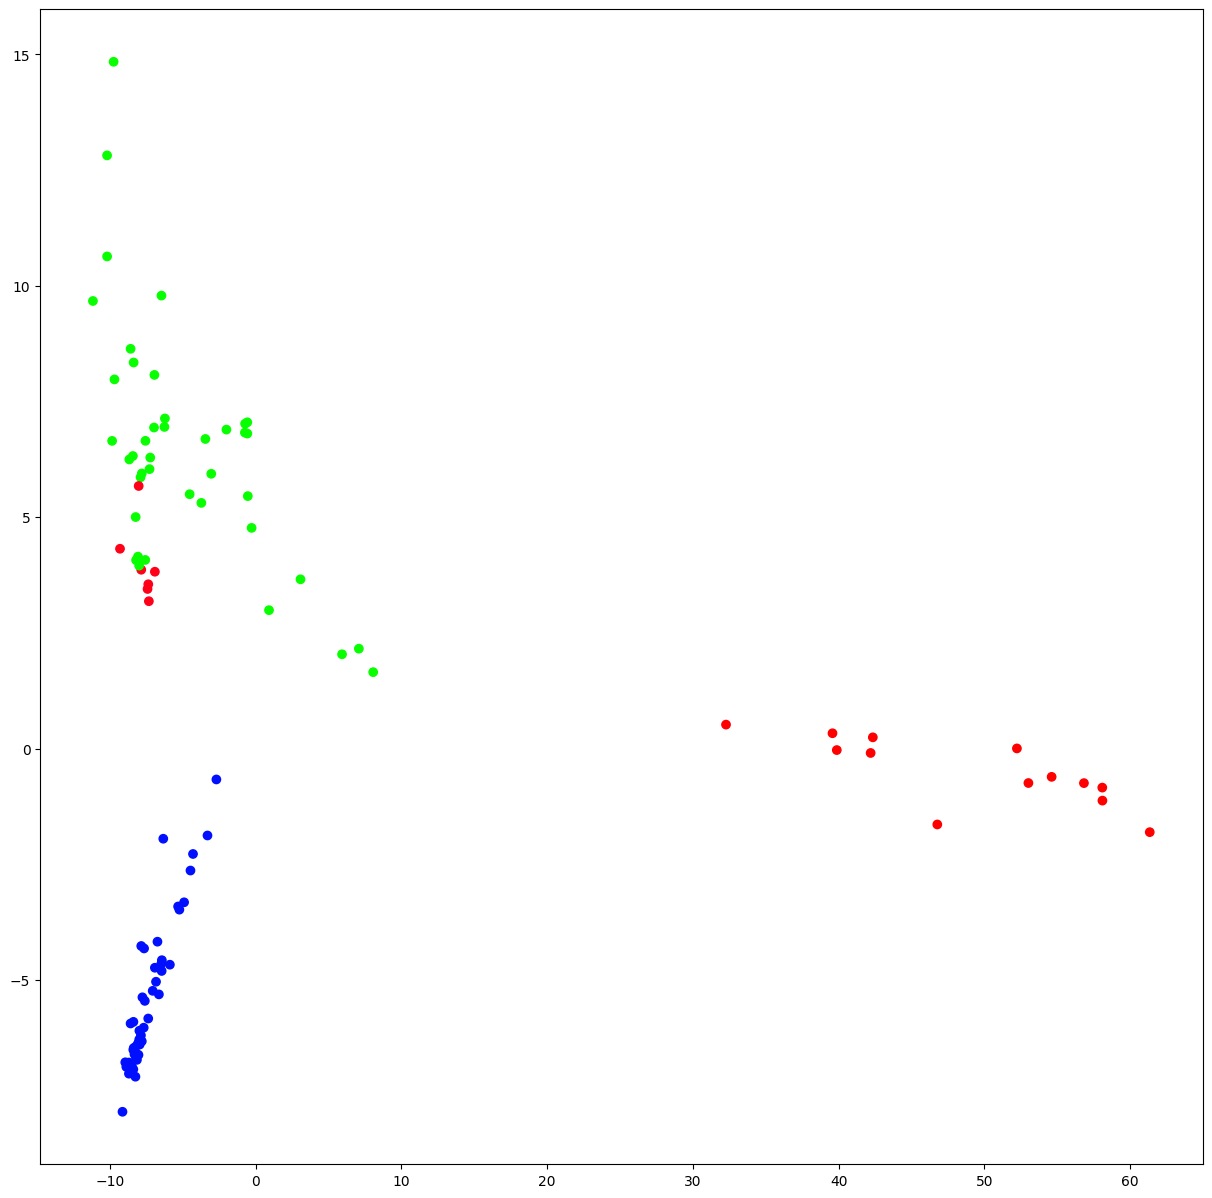

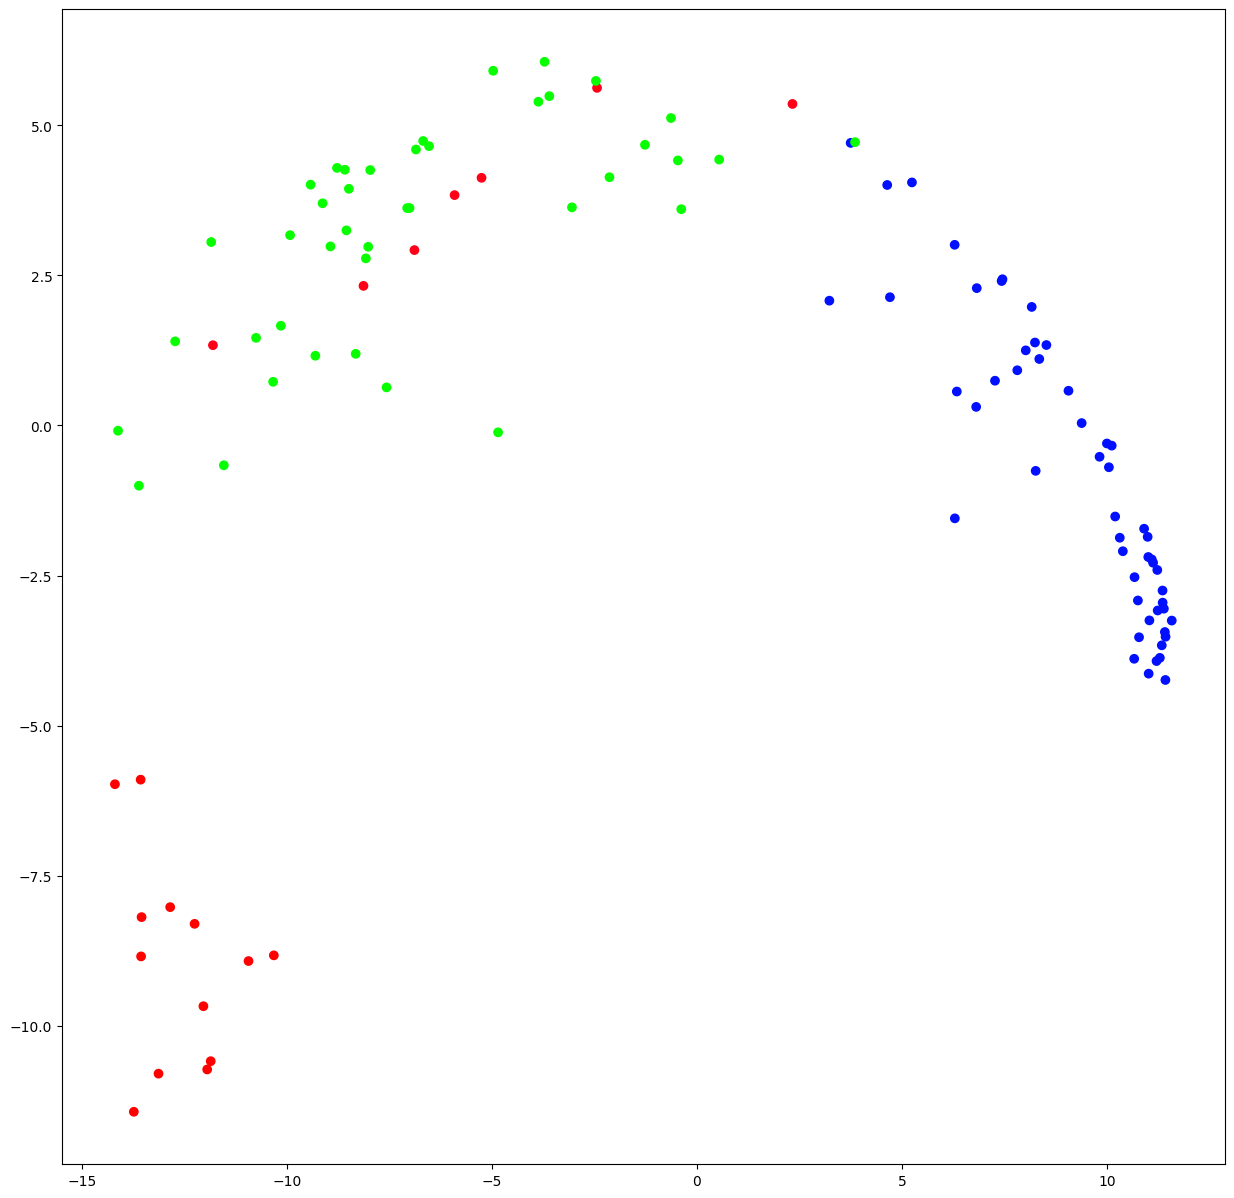

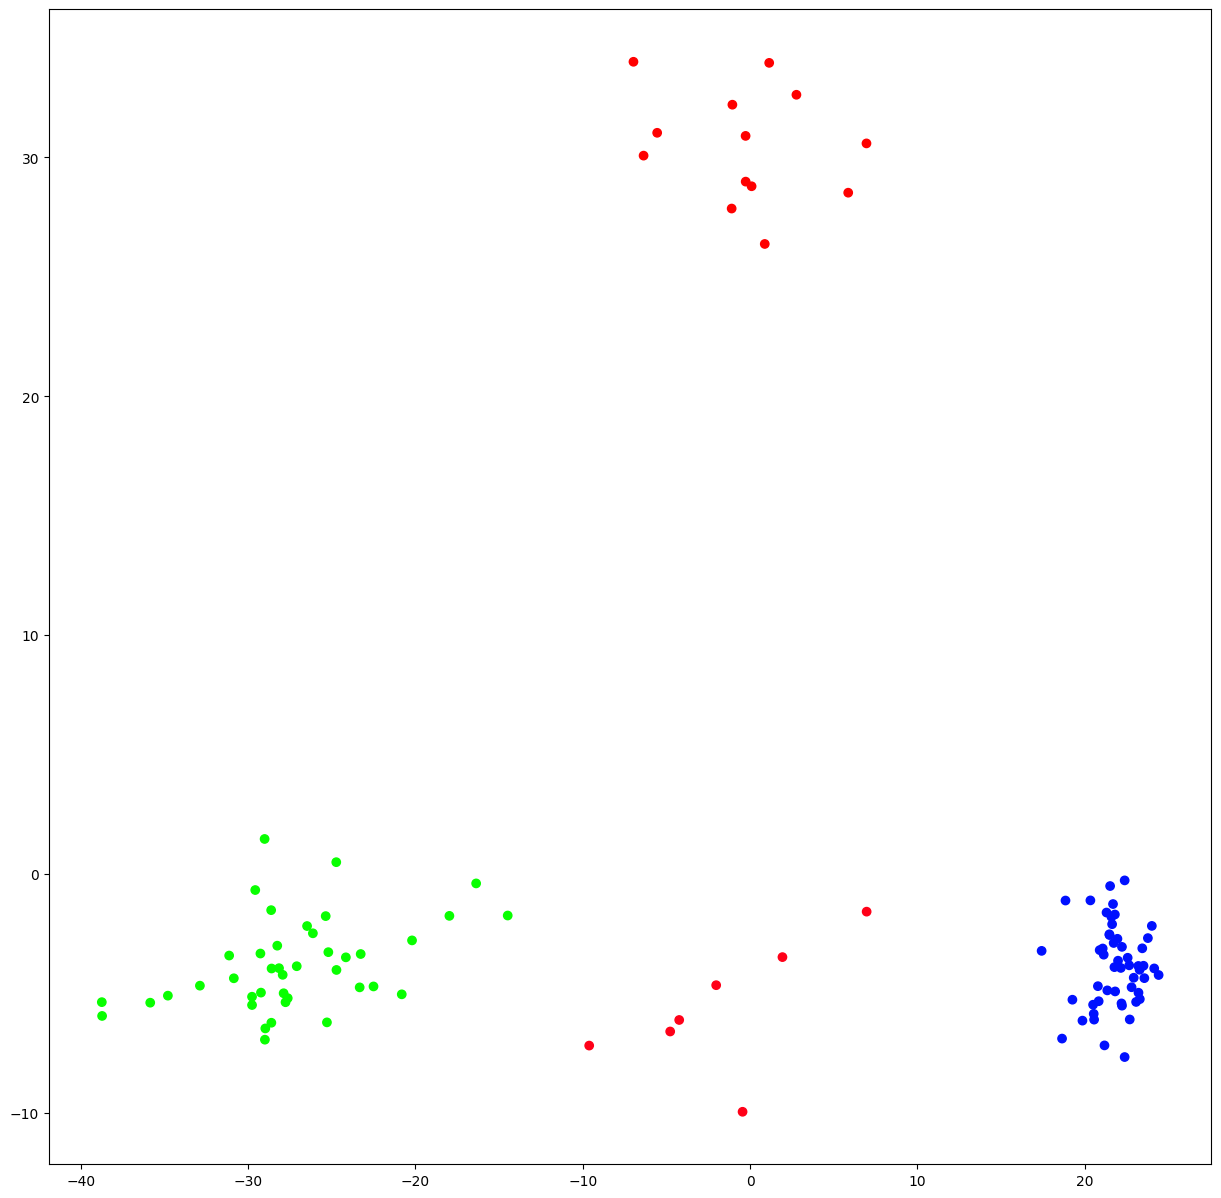

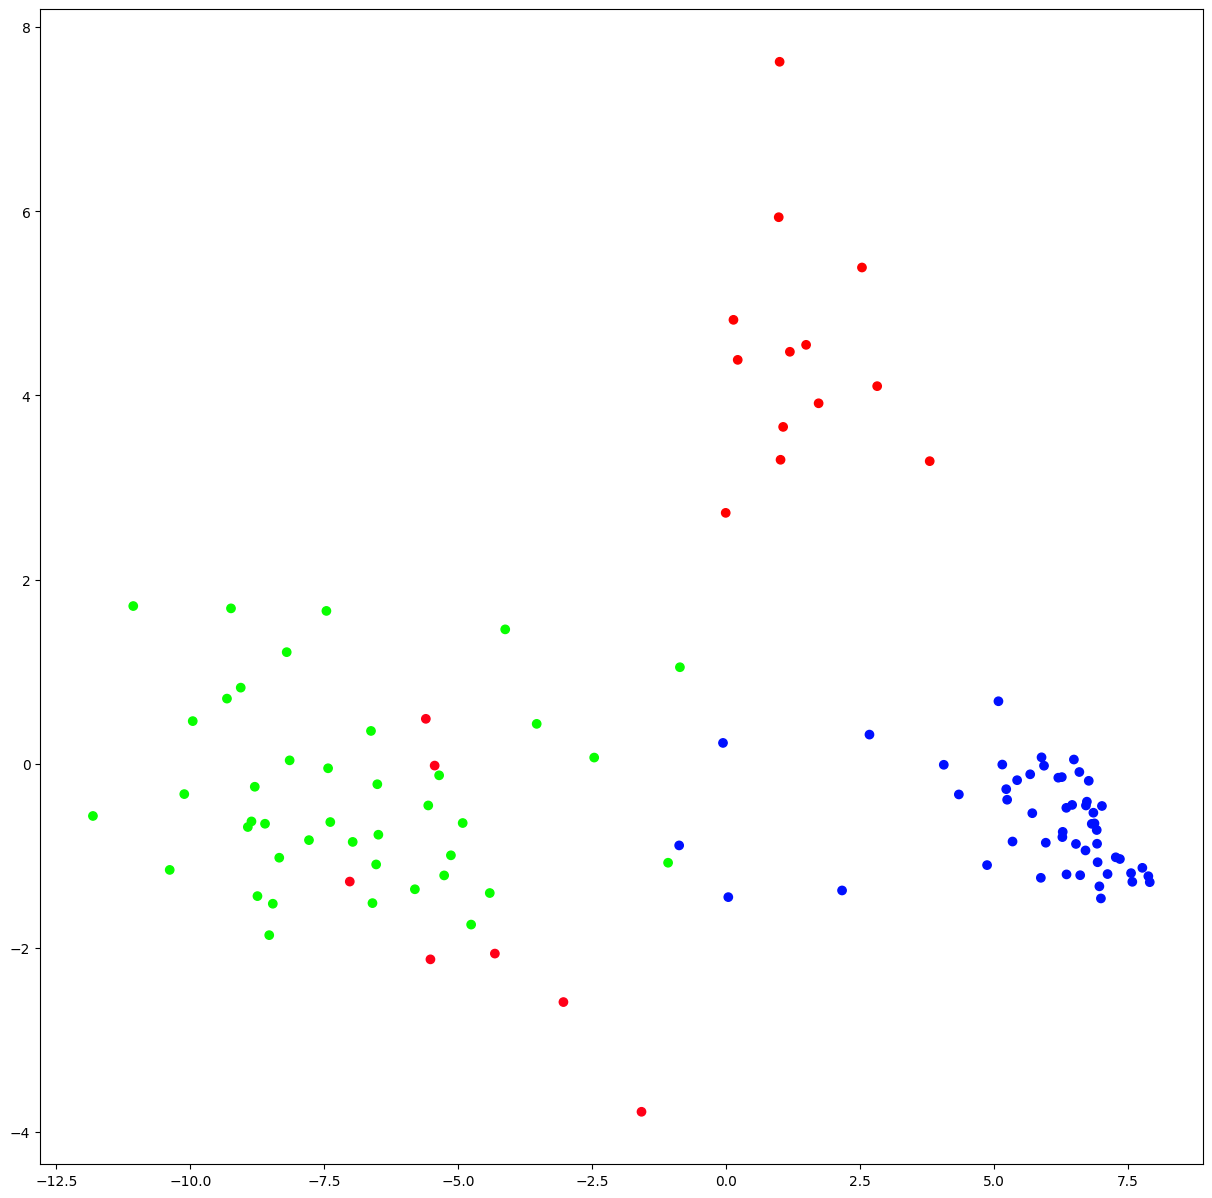

In [46]:
# Get representations for each model
for model in crop_results.values():
    outputs, labels = get_representations(model['model'], train_loader)
    output_pca_data = get_pca(outputs)
    plot_representations(output_pca_data, labels, classes)  # Adjusted to pass only three arguments

In [47]:
def get_tsne(data, n_components=2, n_images=None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

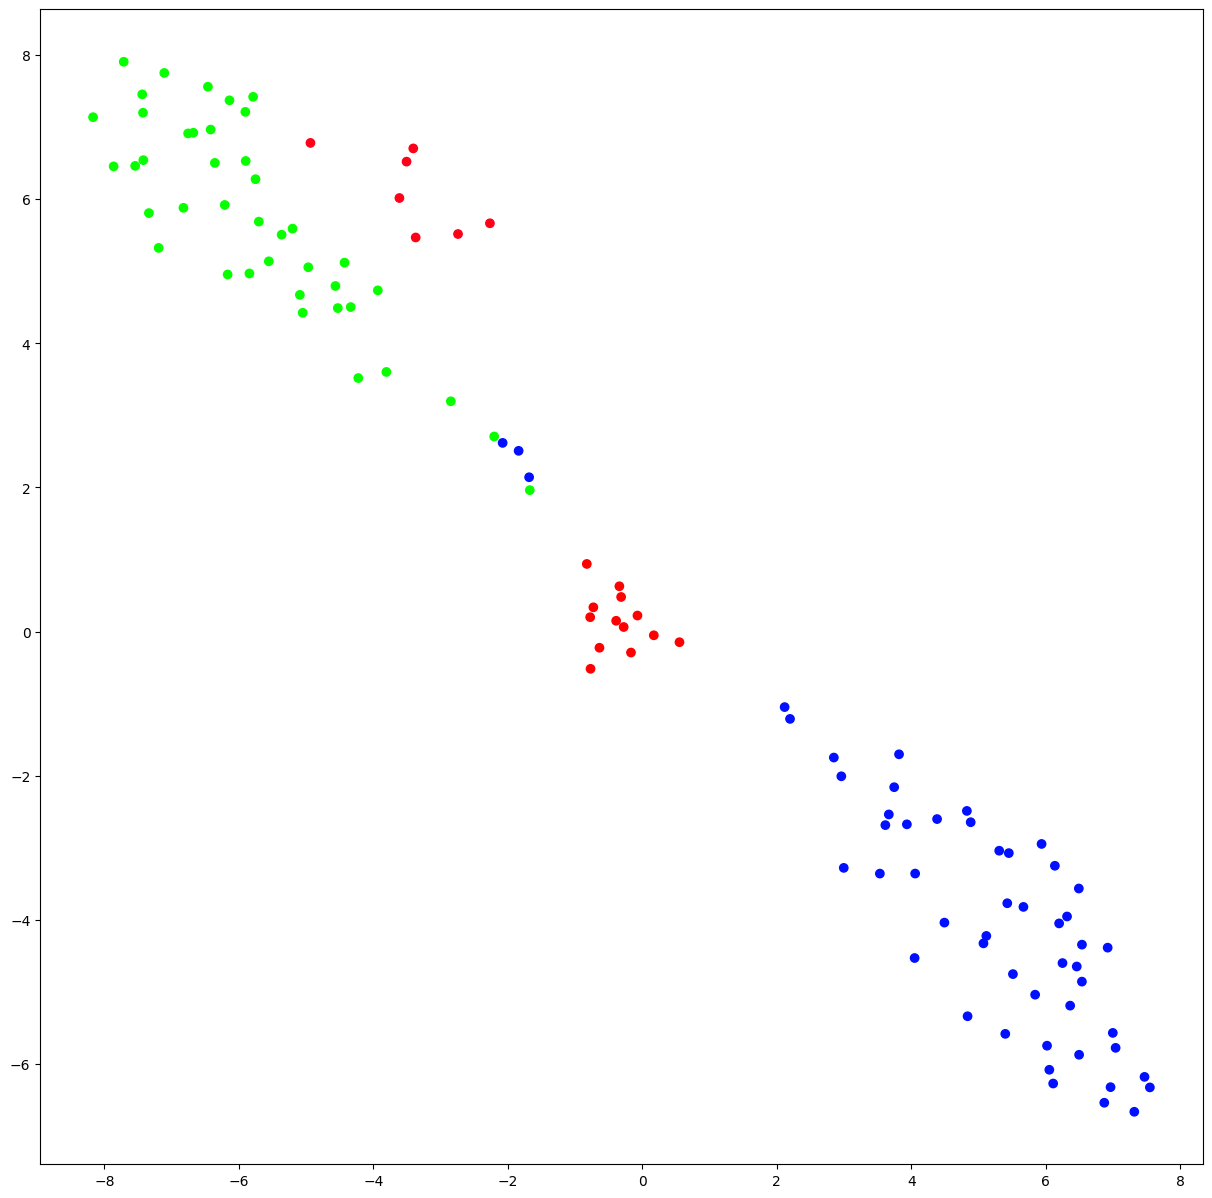

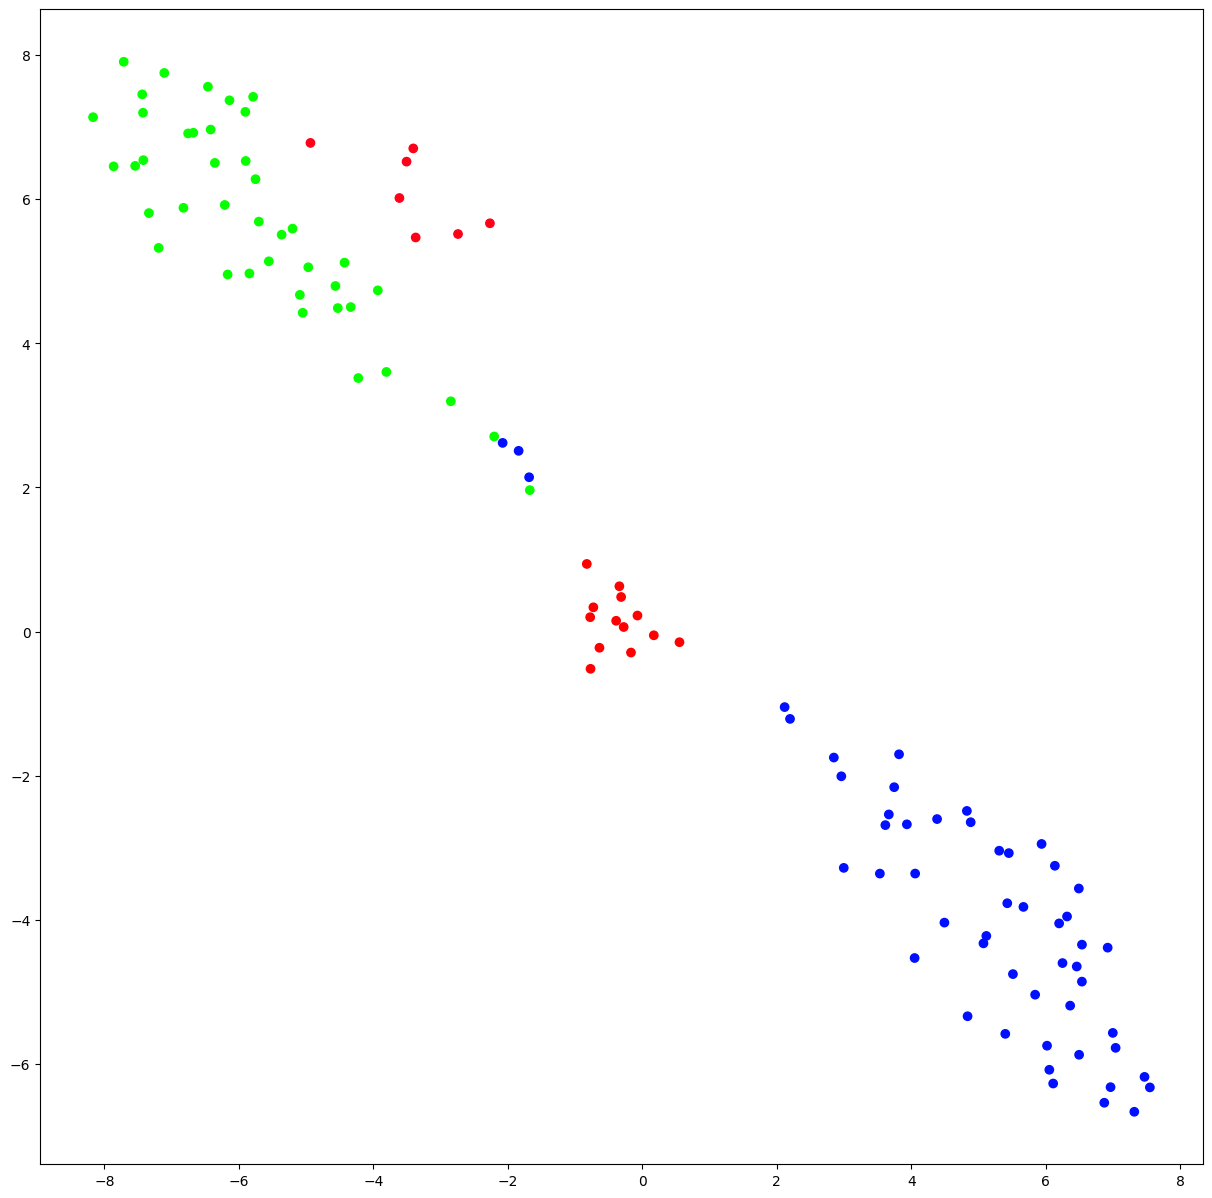

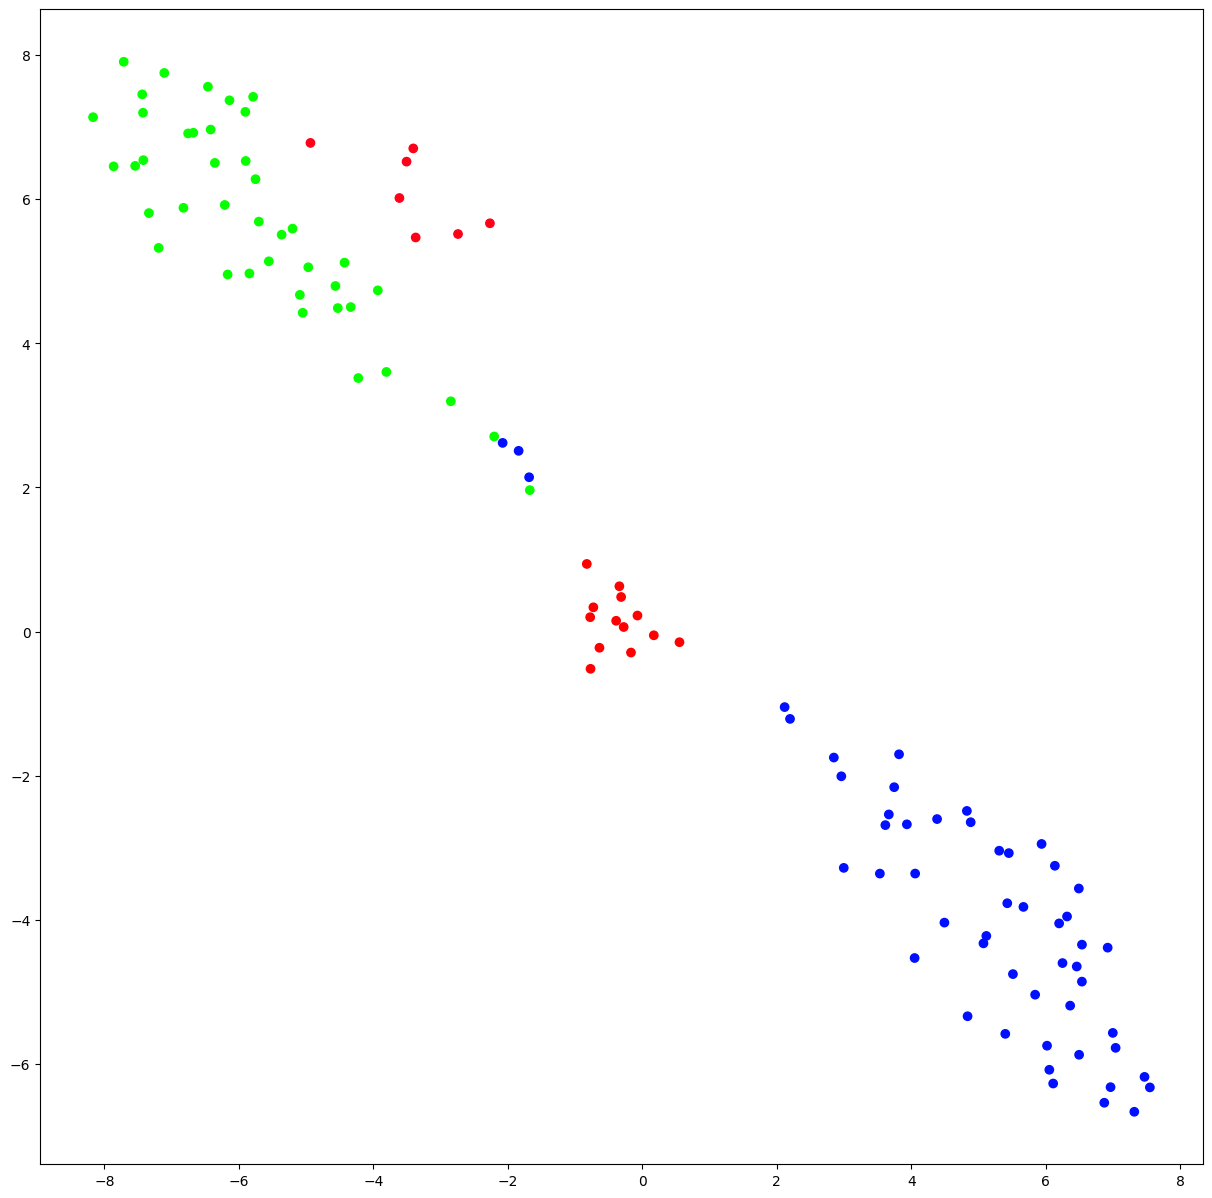

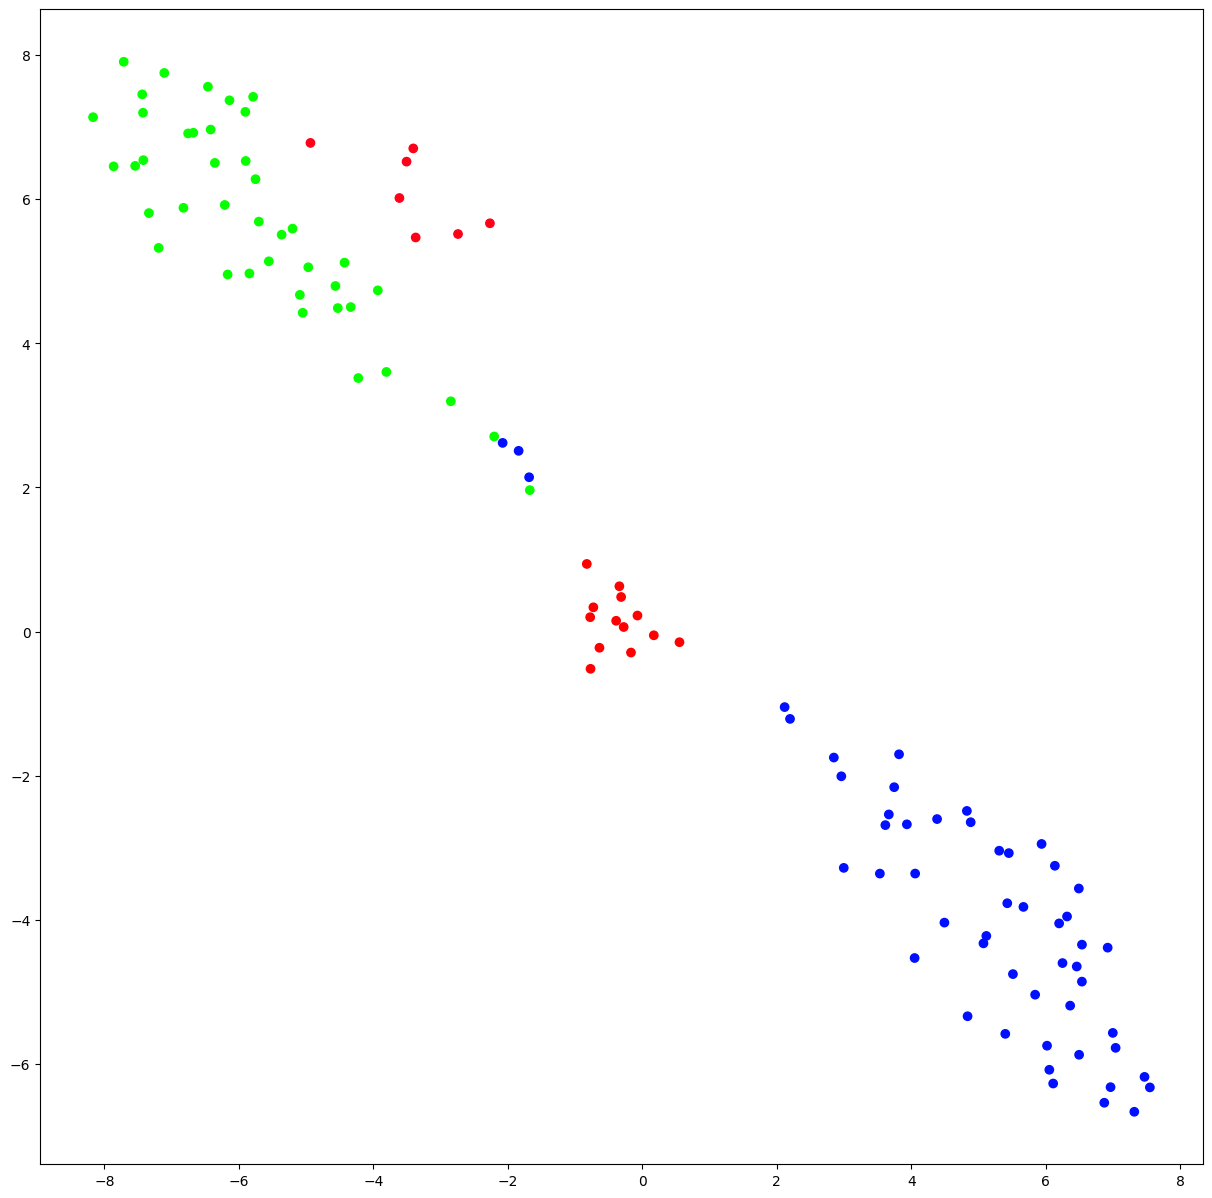

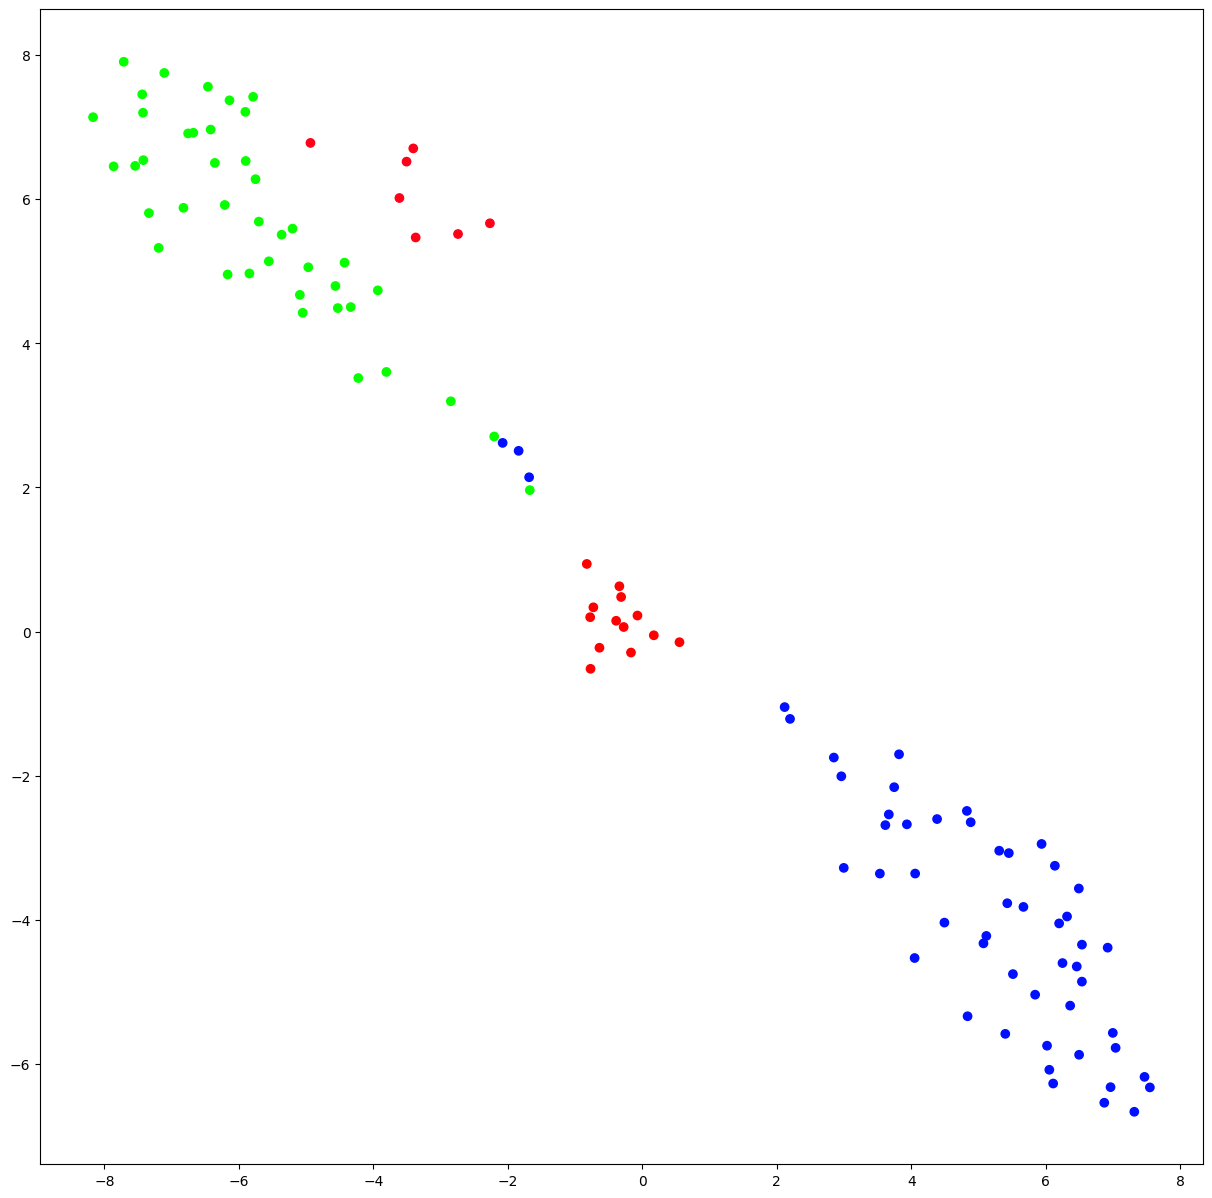

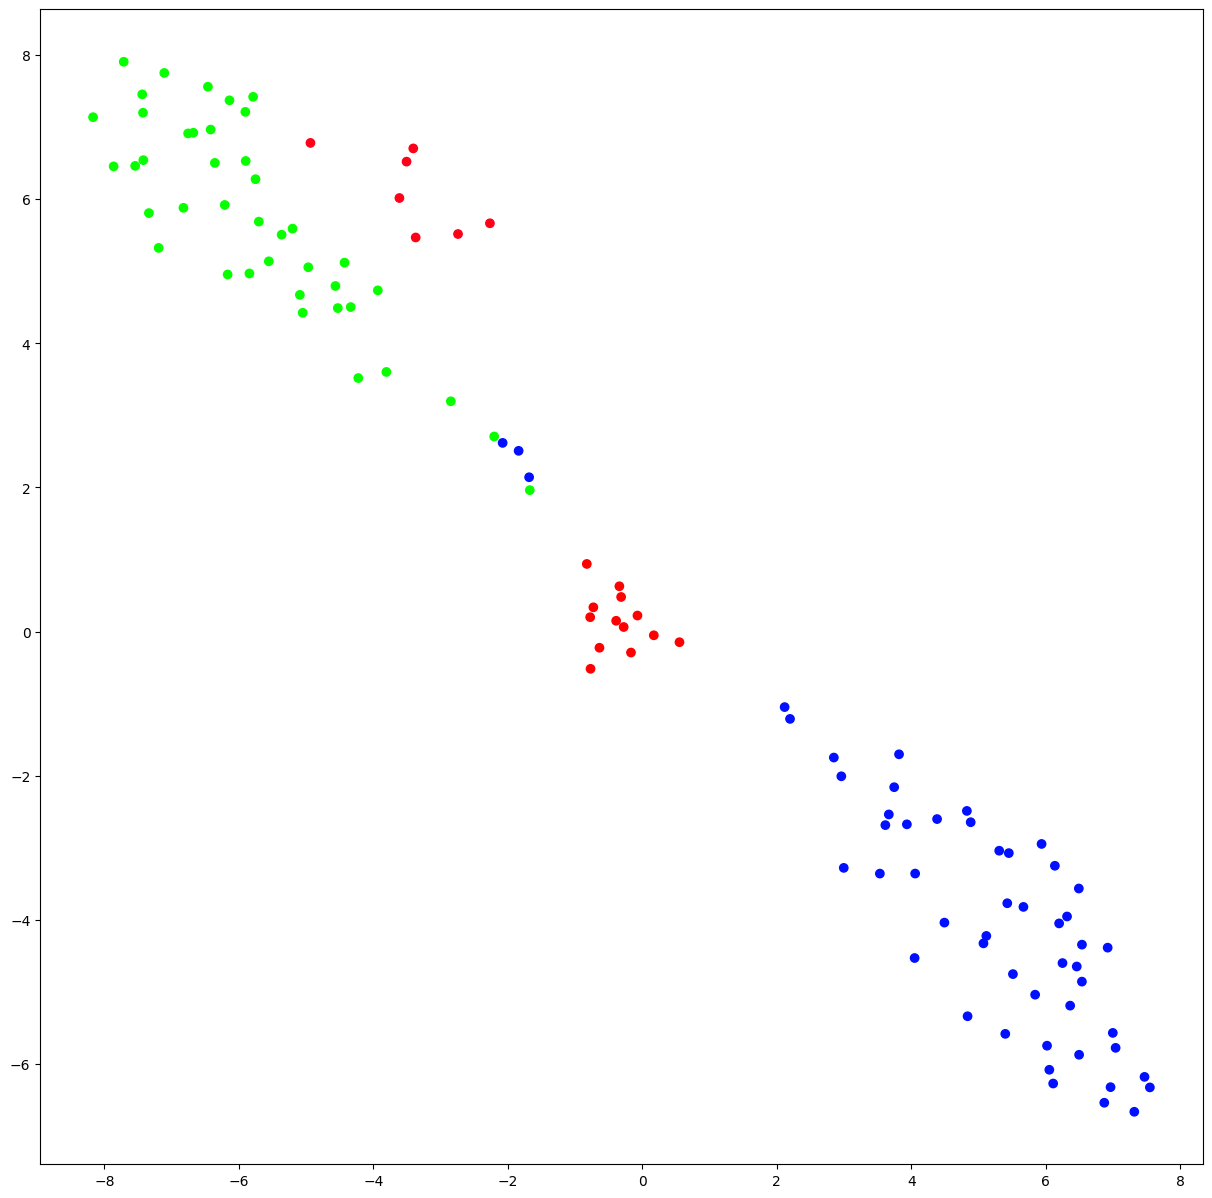

In [48]:

for model_name in crop_results.keys():
    output_tsne_data = get_tsne(outputs)
    plot_representations(output_tsne_data, labels, classes)

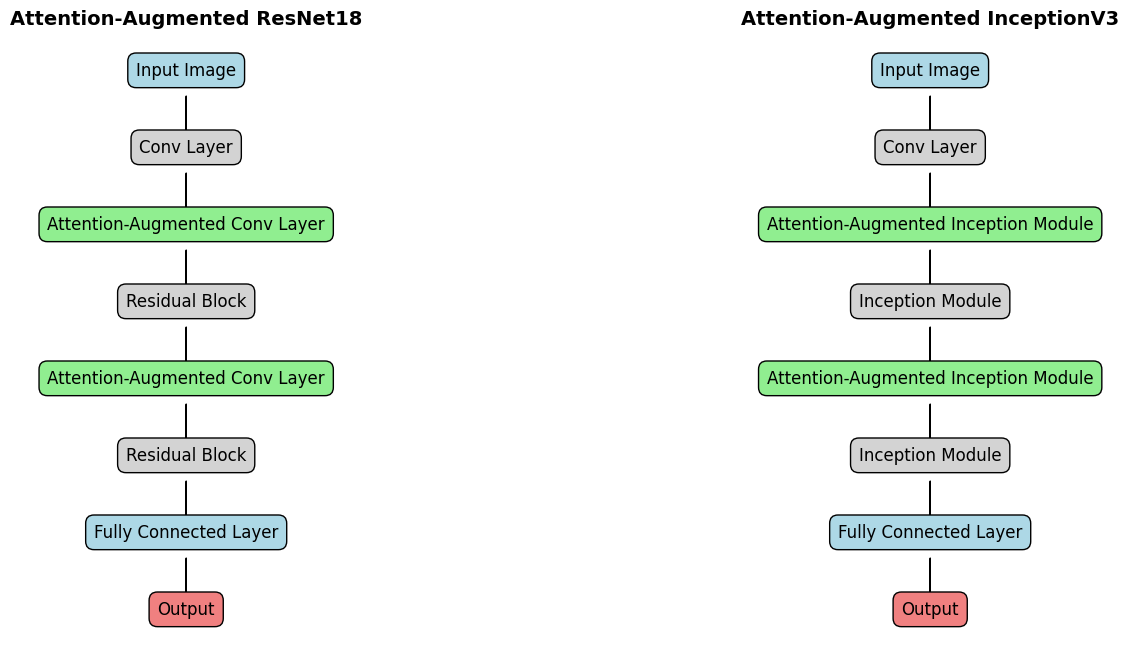

In [49]:
import matplotlib.pyplot as plt

def draw_attention_augmented_architectures_flowchart():
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 12)

    # ResNet18 Architecture
    ax.text(1, 11, 'Input Image', ha='center', va='center', fontsize=12, bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))
    ax.text(1, 9.5, 'Conv Layer', ha='center', va='center', fontsize=12, bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.5'))
    ax.text(1, 8, 'Attention-Augmented Conv Layer', ha='center', va='center', fontsize=12, bbox=dict(facecolor='lightgreen', edgecolor='black', boxstyle='round,pad=0.5'))
    ax.text(1, 6.5, 'Residual Block', ha='center', va='center', fontsize=12, bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.5'))
    ax.text(1, 5, 'Attention-Augmented Conv Layer', ha='center', va='center', fontsize=12, bbox=dict(facecolor='lightgreen', edgecolor='black', boxstyle='round,pad=0.5'))
    ax.text(1, 3.5, 'Residual Block', ha='center', va='center', fontsize=12, bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.5'))
    ax.text(1, 2, 'Fully Connected Layer', ha='center', va='center', fontsize=12, bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))
    ax.text(1, 0.5, 'Output', ha='center', va='center', fontsize=12, bbox=dict(facecolor='lightcoral', edgecolor='black', boxstyle='round,pad=0.5'))

    # InceptionV3 Architecture
    ax.text(9, 11, 'Input Image', ha='center', va='center', fontsize=12, bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))
    ax.text(9, 9.5, 'Conv Layer', ha='center', va='center', fontsize=12, bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.5'))
    ax.text(9, 8, 'Attention-Augmented Inception Module', ha='center', va='center', fontsize=12, bbox=dict(facecolor='lightgreen', edgecolor='black', boxstyle='round,pad=0.5'))
    ax.text(9, 6.5, 'Inception Module', ha='center', va='center', fontsize=12, bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.5'))
    ax.text(9, 5, 'Attention-Augmented Inception Module', ha='center', va='center', fontsize=12, bbox=dict(facecolor='lightgreen', edgecolor='black', boxstyle='round,pad=0.5'))
    ax.text(9, 3.5, 'Inception Module', ha='center', va='center', fontsize=12, bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.5'))
    ax.text(9, 2, 'Fully Connected Layer', ha='center', va='center', fontsize=12, bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=0.5'))
    ax.text(9, 0.5, 'Output', ha='center', va='center', fontsize=12, bbox=dict(facecolor='lightcoral', edgecolor='black', boxstyle='round,pad=0.5'))

    # Arrows for ResNet18
    ax.arrow(1, 10.5, 0, -0.75, head_width=0.2, head_length=0.3, fc='black', ec='black')
    ax.arrow(1, 9, 0, -0.75, head_width=0.2, head_length=0.3, fc='black', ec='black')
    ax.arrow(1, 7.5, 0, -0.75, head_width=0.2, head_length=0.3, fc='black', ec='black')
    ax.arrow(1, 6, 0, -0.75, head_width=0.2, head_length=0.3, fc='black', ec='black')
    ax.arrow(1, 4.5, 0, -0.75, head_width=0.2, head_length=0.3, fc='black', ec='black')
    ax.arrow(1, 3, 0, -0.75, head_width=0.2, head_length=0.3, fc='black', ec='black')
    ax.arrow(1, 1.5, 0, -0.75, head_width=0.2, head_length=0.3, fc='black', ec='black')

    # Arrows for InceptionV3
    ax.arrow(9, 10.5, 0, -0.75, head_width=0.2, head_length=0.3, fc='black', ec='black')
    ax.arrow(9, 9, 0, -0.75, head_width=0.2, head_length=0.3, fc='black', ec='black')
    ax.arrow(9, 7.5, 0, -0.75, head_width=0.2, head_length=0.3, fc='black', ec='black')
    ax.arrow(9, 6, 0, -0.75, head_width=0.2, head_length=0.3, fc='black', ec='black')
    ax.arrow(9, 4.5, 0, -0.75, head_width=0.2, head_length=0.3, fc='black', ec='black')
    ax.arrow(9, 3, 0, -0.75, head_width=0.2, head_length=0.3, fc='black', ec='black')
    ax.arrow(9, 1.5, 0, -0.75, head_width=0.2, head_length=0.3, fc='black', ec='black')

    # Titles
    ax.text(1, 12, 'Attention-Augmented ResNet18', ha='center', va='center', fontsize=14, weight='bold')
    ax.text(9, 12, 'Attention-Augmented InceptionV3', ha='center', va='center', fontsize=14, weight='bold')

    # Hide axes
    ax.axis('off')

    # Save the figure
    plt.savefig('attention_augmented_architectures_flowchart.png')
    plt.show()

draw_attention_augmented_architectures_flowchart()